# <p style="text-align: center;">Base Model for TP2 - Do you need more signs?</p>

### **1. Import the Required Libraries**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

### **2. Load the Image Training and Test Datasets**

#### **i. Get the Image Dataset Paths**

In [15]:
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'
balanced_train_dataset_path = 'data-students/balanced1_data/'


### ii. Load Image Datasets 

We are going for the tiny version of the dataset!

In [3]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

Loading the training dataset. Via DataGenerators

In [16]:
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)


Split the Training Folder in Training / Validation / Test

In [17]:
# Divisão dos dados em treino, validação e teste (10% para validação, 10% para teste)
train_val_idx, test_idx = train_test_split(
    range(len(traffic_signals_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=traffic_signals_dataset.targets
)

train_idx, valid_idx = train_test_split(
    train_val_idx,
    test_size=0.1,
    shuffle=True,
    stratify=[traffic_signals_dataset.targets[i] for i in train_val_idx]
)

train_subset = Subset(traffic_signals_dataset, train_idx)
valid_subset = Subset(traffic_signals_dataset, valid_idx)
test_subset = Subset(traffic_signals_dataset, test_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
testtrain_dataset_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

In [113]:
training_targets = traffic_signals_dataset.targets
t_targets = {k:0 for k in training_targets}
for t in training_targets:
    t_targets[t] += 1
print('Training class distribution:', t_targets)

Training class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


Loading the test dataset.

In [6]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [7]:
### subset version
#the_labels = {value for _, value in train_datagen.class_to_idx.items()}
labels = {value: key for key, value in traffic_signals_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in traffic_signals_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 22: 'Cenas', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 46: 'Unknown', 49: 'Unk1', 50: 'Fences', 54: 'Do Not Park', 55: 'Do', 57: 'Forbidden'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous curve to the right
4 : 39 - Dangerous curve to the left
5 : 44 - Go left or straight
6 : 46 - Unknown
7 : 49 - Unk1
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


### **2. Plotting Sample Training Images**

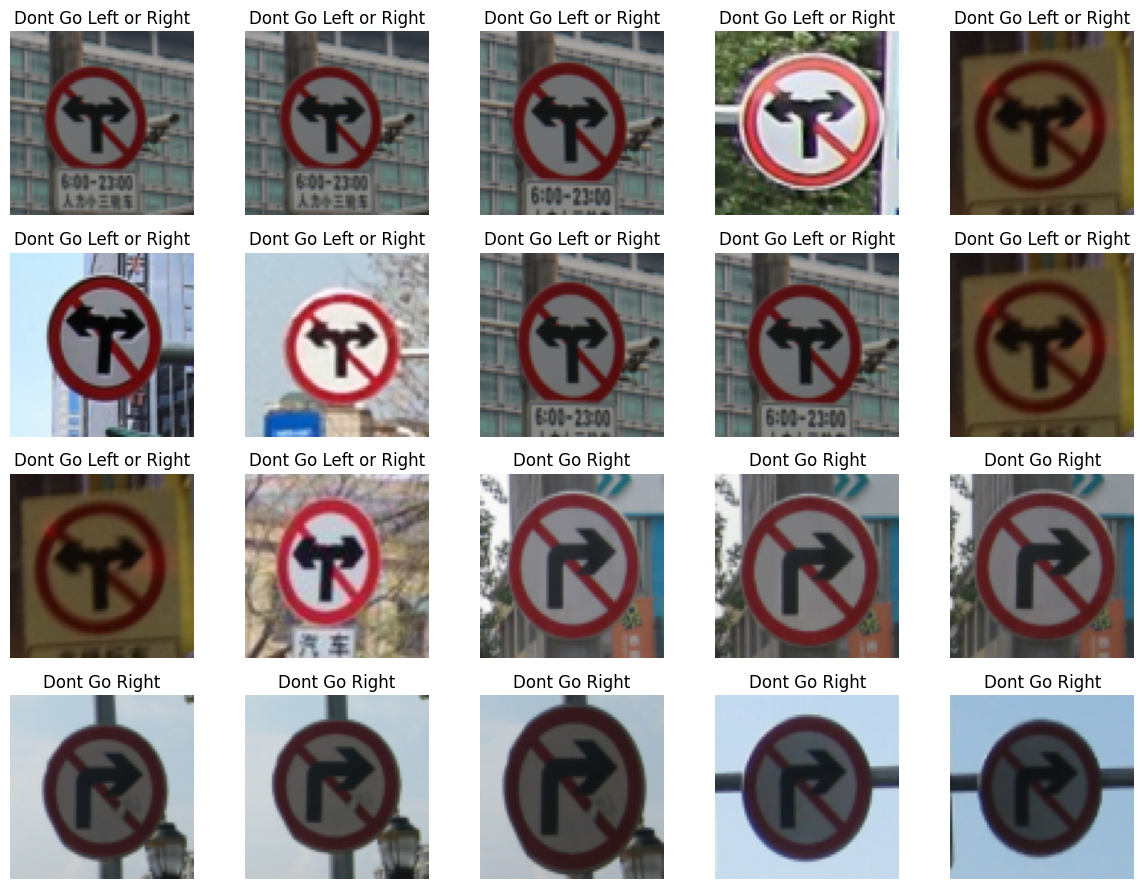

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(traffic_signals_dataset)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
#plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2


In [18]:
def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        print(f"Epoch {epoch+1} average loss: {cumulative_loss/len(train_dataset_loader)}")
    return model.to("cpu")

In [10]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

num_classes = len(labels)
print(num_classes)
print(device)
num_epochs = 15
model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


10
cpu


In [19]:
TRAIN_MODEL = False
if TRAIN_MODEL:
    ccnn = train_model(model, criterion, optimizer, train_dataset_loader, num_epochs, device)
    
else:
    ccnn = torch.load('baseline_model.pth')

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def test_model(model, dataset_loader):
    y_real = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total,100 * correct / total))
    # Generate the confusion matrix
    cm = confusion_matrix(y_real, y_pred)
    report_o = classification_report(y_real, y_pred, output_dict=True)
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    precisions_original = []
    recalls_original = []
    for i in range(num_classes):
        precisions_original.append(report_o[str(i)]['precision'])
        recalls_original.append(report_o[str(i)]['recall'])

    return precisions_original, recalls_original

In [ ]:
print(test_model(ccnn, validation_dataset_loader))

Accuracy of the model on the 28 test images: 85.71428571428571 %


C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

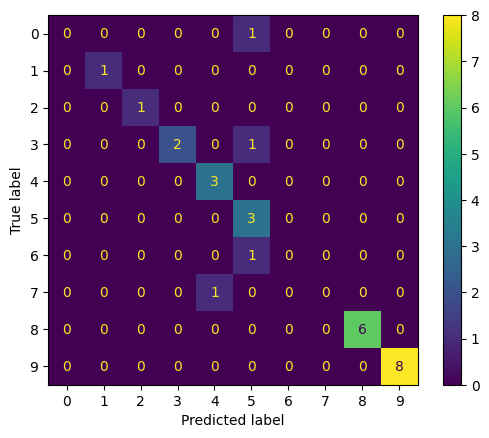

In [21]:
precisions_original, recalls_original = test_model(ccnn, testtrain_dataset_loader)

# AutoEncoder

Autoencoder Simples:

Este autoencoder possui uma arquitetura básica, com uma única camada de convolução para codificação e uma camada de convolução transposta para decodificação. É uma escolha simples e rápida de treinar, adequada para conjuntos de dados menores e imagens simples.
Autoencoder Profundo:

Este autoencoder é mais profundo, com várias camadas de convolução para codificação e decodificação. Ele pode capturar representações mais complexas dos dados, o que pode ser útil para conjuntos de dados maiores e imagens mais detalhadas. No entanto, é mais lento para treinar devido à sua profundidade.
Autoencoder Variacional (VAE):

O VAE é uma variante especial de autoencoder que aprende a gerar novas amostras do conjunto de dados de forma probabilística. Ele introduz uma distribuição latente sobre as representações codificadas, o que permite a geração de novas amostras interpolando entre as representações latentes. Isso pode ser útil para aumentar o conjunto de dados com novas amostras sintéticas.

Depois -> versões com ruído(denoising Autoencoders)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import csv

class DenoisingAutoencoder1(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.1  # Adiciona ruído gaussiano
        x_noisy = x + noise
        x_noisy = torch.clamp(x_noisy, 0., 1.)  # Certifica-se de que os valores estejam no intervalo [0, 1]
        x = self.encoder(x_noisy)
        x = self.decoder(x)
        x = F.interpolate(x, size=(75, 75))
        return x

class DenoisingAutoencoder2(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.1  # Adiciona ruído gaussiano
        x_noisy = x + noise
        x_noisy = torch.clamp(x_noisy, 0., 1.)  # Certifica-se de que os valores estejam no intervalo [0, 1]
        x = self.encoder(x_noisy)
        x = self.decoder(x)
        # Redimensiona a saída para 75x75
        x = F.interpolate(x, size=(75, 75))
        return x

class DenoisingAutoencoder3(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.1  # Adiciona ruído gaussiano
        x_noisy = x + noise
        x_noisy = torch.clamp(x_noisy, 0., 1.)  # Certifica-se de que os valores estejam no intervalo [0, 1]
        x = self.encoder(x_noisy)
        x = self.decoder(x)
        # Redimensiona a saída para 75x75
        x = F.interpolate(x, size=(75, 75))
        return x


class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Redimensiona a saída para 75x75
        x = F.interpolate(x, size=(75, 75))
        return x

class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Redimensiona a saída para 75x75
        x = F.interpolate(x, size=(75, 75))
        return x

class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # Redimensiona a saída para 75x75
        x = F.interpolate(x, size=(75, 75))
        return x

### Experimentação de parâmetros

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import csv

# Lista para armazenar os resultados
results = []

# Definição da função de avaliação do autoencoder
def evaluate_autoencoder(model, criterion, data_loader, device='cpu'):
    model.to(device)
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
    average_loss = total_loss / len(data_loader)
    print(f"Average evaluation loss: {average_loss}")
    return average_loss

# Definição da função de treinamento do autoencoder
def train_autoencoder(model, criterion, optimizer, data_loader, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {cumulative_loss/len(data_loader)}")
    return model.to("cpu")

# Carregamento dos dados
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor()
])


traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

train_idx, valid_idx = train_test_split(
    range(len(traffic_signals_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=traffic_signals_dataset.targets
)

train_subset = Subset(traffic_signals_dataset, train_idx)
valid_subset = Subset(traffic_signals_dataset, valid_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

# Experimentação de diferentes arquiteturas e parâmetros
autoencoders = [Autoencoder1(), Autoencoder2(), Autoencoder3(), DenoisingAutoencoder1(), DenoisingAutoencoder2(), DenoisingAutoencoder3()]
criterions = [nn.MSELoss(), nn.L1Loss()]
optimizers = [optim.Adam, optim.SGD]

best_autoencoder = None
best_loss = float('inf')

for autoencoder in autoencoders:
    for criterion in criterions:
        for optimizer_class in optimizers:
            optimizer = optimizer_class(autoencoder.parameters(), lr=0.001)
            print(f"Training {autoencoder.__class__.__name__} with {criterion.__class__.__name__} and {optimizer_class.__name__}")
            trained_autoencoder = train_autoencoder(autoencoder, criterion, optimizer, train_dataset_loader, num_epochs=20)
            
            # Avaliar o modelo treinado
            evaluation_loss = evaluate_autoencoder(trained_autoencoder, criterion, validation_dataset_loader)
            if evaluation_loss < best_loss:
                best_loss = evaluation_loss
                best_autoencoder = trained_autoencoder
                best_criterion = criterion
                best_optimizer = optimizer_class
                
            # Armazenar os resultados relevantes
            result = {
                "Autoencoder": autoencoder.__class__.__name__,
                "Criterion": criterion.__class__.__name__,
                "Optimizer": optimizer_class.__name__,
                "Evaluation Loss": evaluation_loss
            }
            results.append(result)


# Gravar os resultados em um arquivo CSV
csv_file = "results1.csv"
with open(csv_file, mode='w', newline='') as file:
    fieldnames = ["Autoencoder", "Criterion", "Optimizer", "Evaluation Loss"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    
    writer.writeheader()
    for result in results:
        writer.writerow(result)

print("Results saved to", csv_file)

print(f"Best Autoencoder: {best_autoencoder.__class__.__name__}")
print(f"Best Criterion: {best_criterion.__class__.__name__}")
print(f"Best Optimizer: {best_optimizer.__name__}")

# Salvando o melhor autoencoder treinado
torch.save(best_autoencoder.state_dict(), 'best_autoencoder.pth')


In [ ]:
import pandas as pd
print(f"Best Autoencoder: {best_autoencoder.__class__.__name__}")
print(f"Best Criterion: {best_criterion.__class__.__name__}")
print(f"Best Optimizer: {best_optimizer.__name__}")

resultadosdf = pd.read_csv("results1.csv")
resultadosdf.head()

Resultados :
* Melhor Autoencoder -> Denoising Autoencoder2
* Melhor critério -> MSELoss
* Melhor Otimizador -> SGD

# Treinar o melhor AutoEncoder

Training autoencoder for class 50
Class: 50, Epoch 1/500, Train Loss: 0.0476, Valid Loss: 0.0446


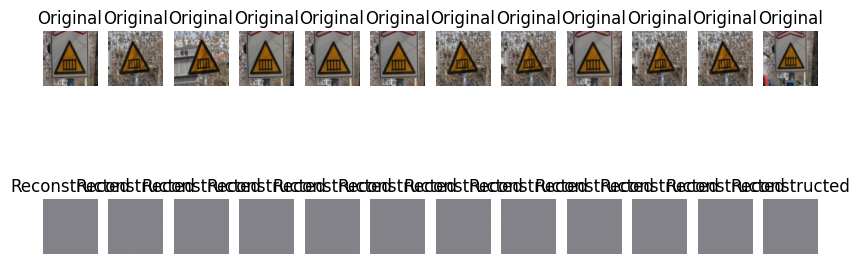

Class: 50, Epoch 2/500, Train Loss: 0.0474, Valid Loss: 0.0445
Class: 50, Epoch 3/500, Train Loss: 0.0473, Valid Loss: 0.0444
Class: 50, Epoch 4/500, Train Loss: 0.0473, Valid Loss: 0.0443
Class: 50, Epoch 5/500, Train Loss: 0.0472, Valid Loss: 0.0443
Class: 50, Epoch 6/500, Train Loss: 0.0471, Valid Loss: 0.0442
Class: 50, Epoch 7/500, Train Loss: 0.0470, Valid Loss: 0.0441
Class: 50, Epoch 8/500, Train Loss: 0.0470, Valid Loss: 0.0441
Class: 50, Epoch 9/500, Train Loss: 0.0469, Valid Loss: 0.0440
Class: 50, Epoch 10/500, Train Loss: 0.0468, Valid Loss: 0.0439
Class: 50, Epoch 11/500, Train Loss: 0.0467, Valid Loss: 0.0438


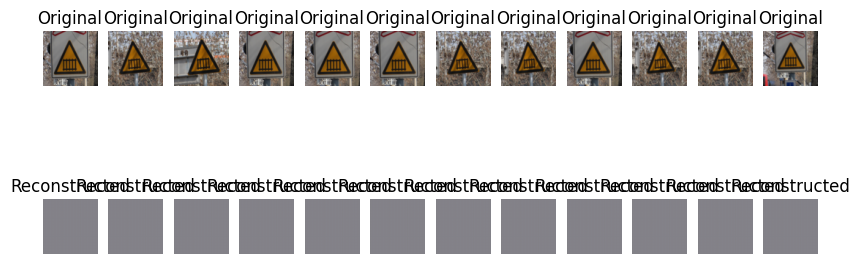

Class: 50, Epoch 12/500, Train Loss: 0.0467, Valid Loss: 0.0438
Class: 50, Epoch 13/500, Train Loss: 0.0466, Valid Loss: 0.0437
Class: 50, Epoch 14/500, Train Loss: 0.0465, Valid Loss: 0.0436
Class: 50, Epoch 15/500, Train Loss: 0.0464, Valid Loss: 0.0435
Class: 50, Epoch 16/500, Train Loss: 0.0463, Valid Loss: 0.0433
Class: 50, Epoch 17/500, Train Loss: 0.0462, Valid Loss: 0.0432
Class: 50, Epoch 18/500, Train Loss: 0.0460, Valid Loss: 0.0430
Class: 50, Epoch 19/500, Train Loss: 0.0458, Valid Loss: 0.0427
Class: 50, Epoch 20/500, Train Loss: 0.0456, Valid Loss: 0.0424
Class: 50, Epoch 21/500, Train Loss: 0.0453, Valid Loss: 0.0420


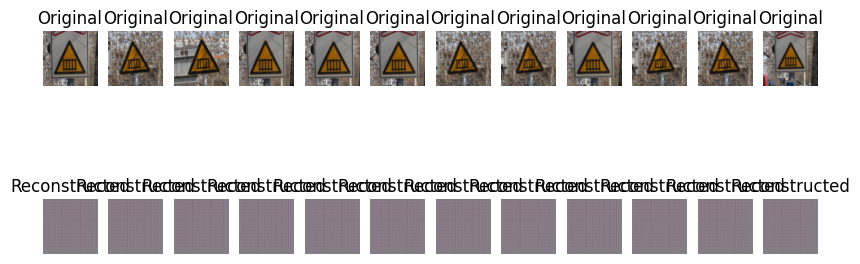

Class: 50, Epoch 22/500, Train Loss: 0.0449, Valid Loss: 0.0414
Class: 50, Epoch 23/500, Train Loss: 0.0444, Valid Loss: 0.0408
Class: 50, Epoch 24/500, Train Loss: 0.0439, Valid Loss: 0.0402
Class: 50, Epoch 25/500, Train Loss: 0.0432, Valid Loss: 0.0394
Class: 50, Epoch 26/500, Train Loss: 0.0424, Valid Loss: 0.0383
Class: 50, Epoch 27/500, Train Loss: 0.0414, Valid Loss: 0.0372
Class: 50, Epoch 28/500, Train Loss: 0.0403, Valid Loss: 0.0359
Class: 50, Epoch 29/500, Train Loss: 0.0388, Valid Loss: 0.0344
Class: 50, Epoch 30/500, Train Loss: 0.0372, Valid Loss: 0.0334
Class: 50, Epoch 31/500, Train Loss: 0.0360, Valid Loss: 0.0327


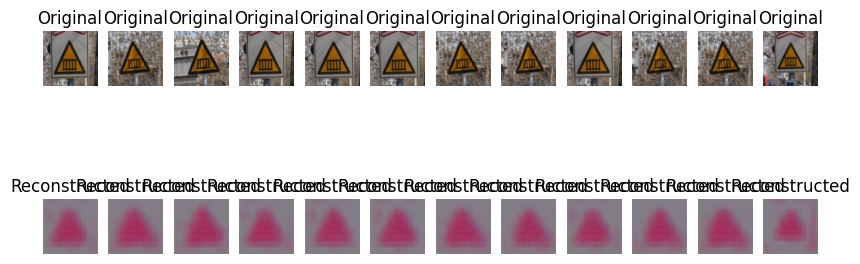

Class: 50, Epoch 32/500, Train Loss: 0.0353, Valid Loss: 0.0320
Class: 50, Epoch 33/500, Train Loss: 0.0345, Valid Loss: 0.0309
Class: 50, Epoch 34/500, Train Loss: 0.0335, Valid Loss: 0.0298
Class: 50, Epoch 35/500, Train Loss: 0.0323, Valid Loss: 0.0293
Class: 50, Epoch 36/500, Train Loss: 0.0316, Valid Loss: 0.0279
Class: 50, Epoch 37/500, Train Loss: 0.0306, Valid Loss: 0.0267
Class: 50, Epoch 38/500, Train Loss: 0.0290, Valid Loss: 0.0254
Class: 50, Epoch 39/500, Train Loss: 0.0277, Valid Loss: 0.0236
Class: 50, Epoch 40/500, Train Loss: 0.0264, Valid Loss: 0.0224
Class: 50, Epoch 41/500, Train Loss: 0.0250, Valid Loss: 0.0216


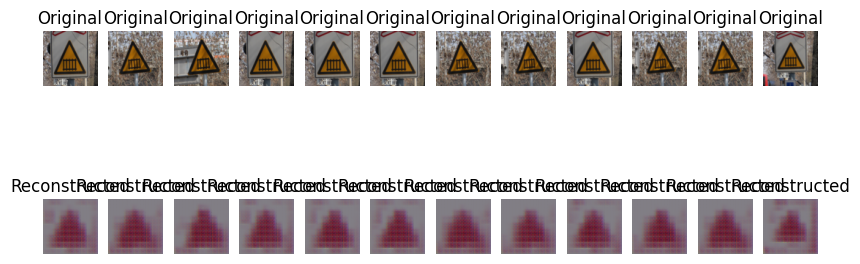

Class: 50, Epoch 42/500, Train Loss: 0.0240, Valid Loss: 0.0202
Class: 50, Epoch 43/500, Train Loss: 0.0228, Valid Loss: 0.0193
Class: 50, Epoch 44/500, Train Loss: 0.0221, Valid Loss: 0.0189
Class: 50, Epoch 45/500, Train Loss: 0.0212, Valid Loss: 0.0183
Class: 50, Epoch 46/500, Train Loss: 0.0206, Valid Loss: 0.0178
Class: 50, Epoch 47/500, Train Loss: 0.0204, Valid Loss: 0.0182
Class: 50, Epoch 48/500, Train Loss: 0.0202, Valid Loss: 0.0172
Class: 50, Epoch 49/500, Train Loss: 0.0197, Valid Loss: 0.0171
Class: 50, Epoch 50/500, Train Loss: 0.0192, Valid Loss: 0.0172
Class: 50, Epoch 51/500, Train Loss: 0.0191, Valid Loss: 0.0168


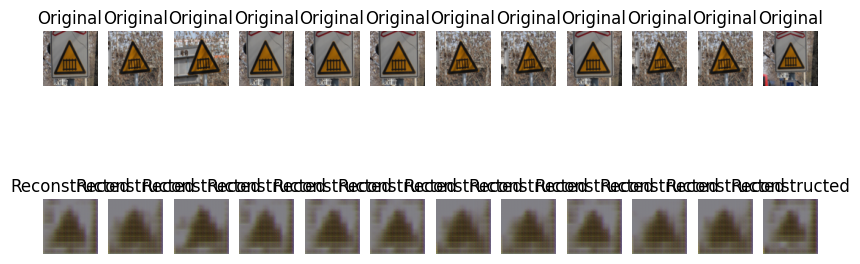

Class: 50, Epoch 52/500, Train Loss: 0.0190, Valid Loss: 0.0171
Class: 50, Epoch 53/500, Train Loss: 0.0188, Valid Loss: 0.0165
Class: 50, Epoch 54/500, Train Loss: 0.0184, Valid Loss: 0.0163
Class: 50, Epoch 55/500, Train Loss: 0.0182, Valid Loss: 0.0168
Class: 50, Epoch 56/500, Train Loss: 0.0183, Valid Loss: 0.0162
Class: 50, Epoch 57/500, Train Loss: 0.0183, Valid Loss: 0.0165
Class: 50, Epoch 58/500, Train Loss: 0.0179, Valid Loss: 0.0157
Class: 50, Epoch 59/500, Train Loss: 0.0173, Valid Loss: 0.0156
Class: 50, Epoch 60/500, Train Loss: 0.0176, Valid Loss: 0.0161
Class: 50, Epoch 61/500, Train Loss: 0.0174, Valid Loss: 0.0153


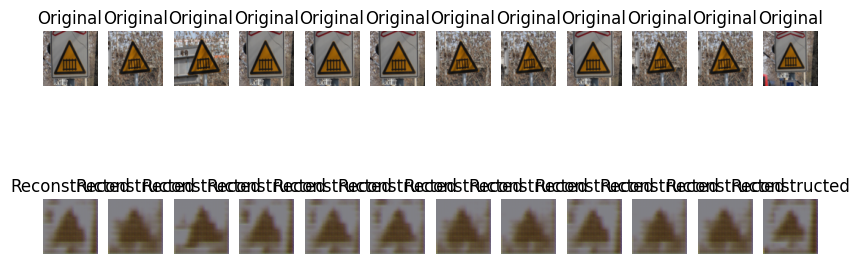

Class: 50, Epoch 62/500, Train Loss: 0.0169, Valid Loss: 0.0153
Class: 50, Epoch 63/500, Train Loss: 0.0172, Valid Loss: 0.0154
Class: 50, Epoch 64/500, Train Loss: 0.0168, Valid Loss: 0.0153
Class: 50, Epoch 65/500, Train Loss: 0.0166, Valid Loss: 0.0149
Class: 50, Epoch 66/500, Train Loss: 0.0167, Valid Loss: 0.0148
Class: 50, Epoch 67/500, Train Loss: 0.0164, Valid Loss: 0.0152
Class: 50, Epoch 68/500, Train Loss: 0.0165, Valid Loss: 0.0146
Class: 50, Epoch 69/500, Train Loss: 0.0162, Valid Loss: 0.0146
Class: 50, Epoch 70/500, Train Loss: 0.0163, Valid Loss: 0.0149
Class: 50, Epoch 71/500, Train Loss: 0.0163, Valid Loss: 0.0146


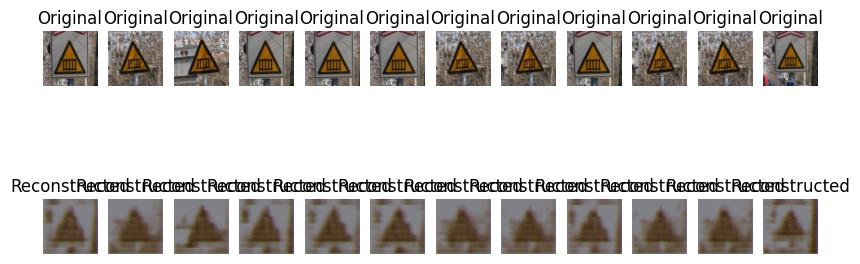

Class: 50, Epoch 72/500, Train Loss: 0.0161, Valid Loss: 0.0145
Class: 50, Epoch 73/500, Train Loss: 0.0162, Valid Loss: 0.0144
Class: 50, Epoch 74/500, Train Loss: 0.0159, Valid Loss: 0.0147
Class: 50, Epoch 75/500, Train Loss: 0.0160, Valid Loss: 0.0143
Class: 50, Epoch 76/500, Train Loss: 0.0158, Valid Loss: 0.0142
Class: 50, Epoch 77/500, Train Loss: 0.0158, Valid Loss: 0.0145
Class: 50, Epoch 78/500, Train Loss: 0.0158, Valid Loss: 0.0142
Class: 50, Epoch 79/500, Train Loss: 0.0156, Valid Loss: 0.0142
Class: 50, Epoch 80/500, Train Loss: 0.0157, Valid Loss: 0.0142
Class: 50, Epoch 81/500, Train Loss: 0.0155, Valid Loss: 0.0141


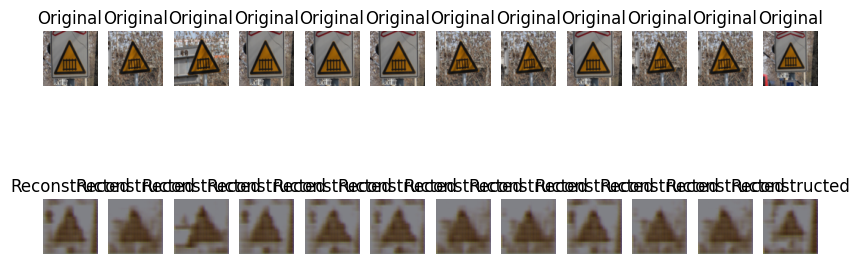

Class: 50, Epoch 82/500, Train Loss: 0.0155, Valid Loss: 0.0139
Class: 50, Epoch 83/500, Train Loss: 0.0154, Valid Loss: 0.0139
Class: 50, Epoch 84/500, Train Loss: 0.0152, Valid Loss: 0.0141
Class: 50, Epoch 85/500, Train Loss: 0.0153, Valid Loss: 0.0138
Class: 50, Epoch 86/500, Train Loss: 0.0152, Valid Loss: 0.0137
Class: 50, Epoch 87/500, Train Loss: 0.0151, Valid Loss: 0.0140
Class: 50, Epoch 88/500, Train Loss: 0.0152, Valid Loss: 0.0136
Class: 50, Epoch 89/500, Train Loss: 0.0151, Valid Loss: 0.0136
Class: 50, Epoch 90/500, Train Loss: 0.0150, Valid Loss: 0.0138
Class: 50, Epoch 91/500, Train Loss: 0.0151, Valid Loss: 0.0135


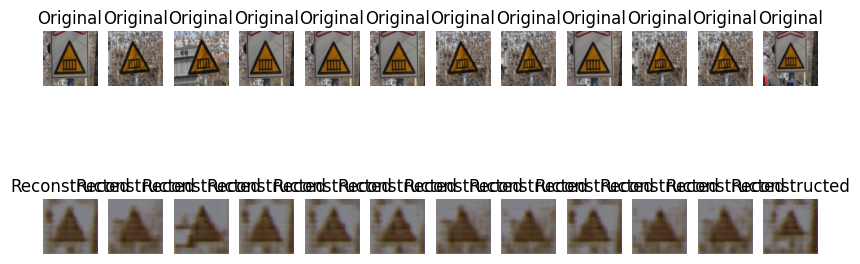

Class: 50, Epoch 92/500, Train Loss: 0.0150, Valid Loss: 0.0135
Class: 50, Epoch 93/500, Train Loss: 0.0149, Valid Loss: 0.0136
Class: 50, Epoch 94/500, Train Loss: 0.0149, Valid Loss: 0.0134
Class: 50, Epoch 95/500, Train Loss: 0.0149, Valid Loss: 0.0135
Class: 50, Epoch 96/500, Train Loss: 0.0147, Valid Loss: 0.0134
Class: 50, Epoch 97/500, Train Loss: 0.0147, Valid Loss: 0.0133
Class: 50, Epoch 98/500, Train Loss: 0.0147, Valid Loss: 0.0134
Class: 50, Epoch 99/500, Train Loss: 0.0146, Valid Loss: 0.0133
Class: 50, Epoch 100/500, Train Loss: 0.0146, Valid Loss: 0.0132
Class: 50, Epoch 101/500, Train Loss: 0.0146, Valid Loss: 0.0134


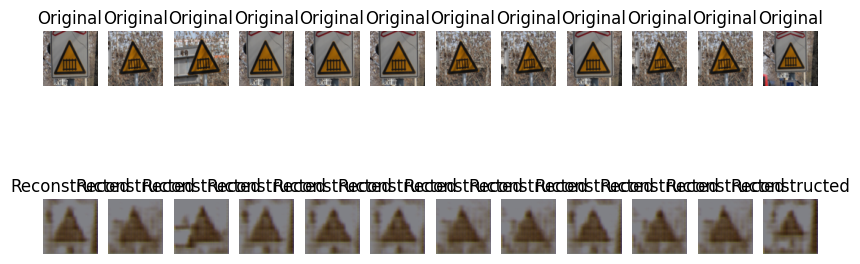

Class: 50, Epoch 102/500, Train Loss: 0.0146, Valid Loss: 0.0131
Class: 50, Epoch 103/500, Train Loss: 0.0145, Valid Loss: 0.0131
Class: 50, Epoch 104/500, Train Loss: 0.0145, Valid Loss: 0.0133
Class: 50, Epoch 105/500, Train Loss: 0.0145, Valid Loss: 0.0131
Class: 50, Epoch 106/500, Train Loss: 0.0144, Valid Loss: 0.0131
Class: 50, Epoch 107/500, Train Loss: 0.0143, Valid Loss: 0.0131
Class: 50, Epoch 108/500, Train Loss: 0.0143, Valid Loss: 0.0129
Class: 50, Epoch 109/500, Train Loss: 0.0143, Valid Loss: 0.0131
Class: 50, Epoch 110/500, Train Loss: 0.0143, Valid Loss: 0.0129
Class: 50, Epoch 111/500, Train Loss: 0.0142, Valid Loss: 0.0129


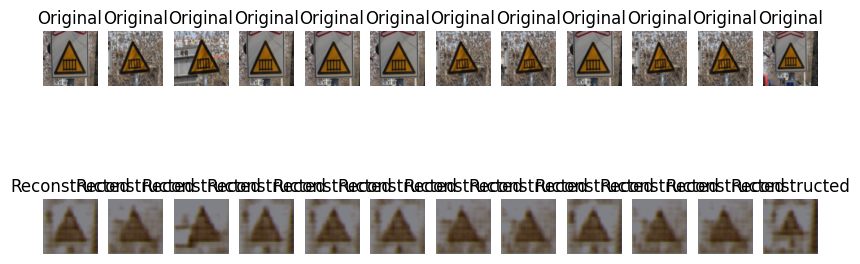

Class: 50, Epoch 112/500, Train Loss: 0.0142, Valid Loss: 0.0129
Class: 50, Epoch 113/500, Train Loss: 0.0142, Valid Loss: 0.0128
Class: 50, Epoch 114/500, Train Loss: 0.0142, Valid Loss: 0.0131
Class: 50, Epoch 115/500, Train Loss: 0.0143, Valid Loss: 0.0128
Class: 50, Epoch 116/500, Train Loss: 0.0142, Valid Loss: 0.0128
Class: 50, Epoch 117/500, Train Loss: 0.0140, Valid Loss: 0.0127
Class: 50, Epoch 118/500, Train Loss: 0.0140, Valid Loss: 0.0127
Class: 50, Epoch 119/500, Train Loss: 0.0140, Valid Loss: 0.0130
Class: 50, Epoch 120/500, Train Loss: 0.0141, Valid Loss: 0.0127
Class: 50, Epoch 121/500, Train Loss: 0.0141, Valid Loss: 0.0127


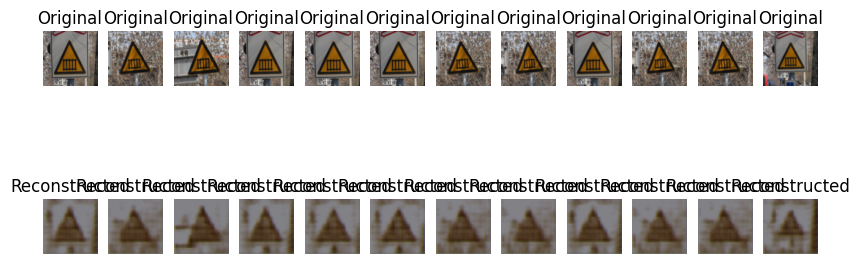

Class: 50, Epoch 122/500, Train Loss: 0.0139, Valid Loss: 0.0127
Class: 50, Epoch 123/500, Train Loss: 0.0139, Valid Loss: 0.0126
Class: 50, Epoch 124/500, Train Loss: 0.0139, Valid Loss: 0.0127
Class: 50, Epoch 125/500, Train Loss: 0.0139, Valid Loss: 0.0126
Class: 50, Epoch 126/500, Train Loss: 0.0138, Valid Loss: 0.0125
Class: 50, Epoch 127/500, Train Loss: 0.0138, Valid Loss: 0.0127
Class: 50, Epoch 128/500, Train Loss: 0.0138, Valid Loss: 0.0125
Class: 50, Epoch 129/500, Train Loss: 0.0137, Valid Loss: 0.0125
Class: 50, Epoch 130/500, Train Loss: 0.0137, Valid Loss: 0.0125
Class: 50, Epoch 131/500, Train Loss: 0.0137, Valid Loss: 0.0124


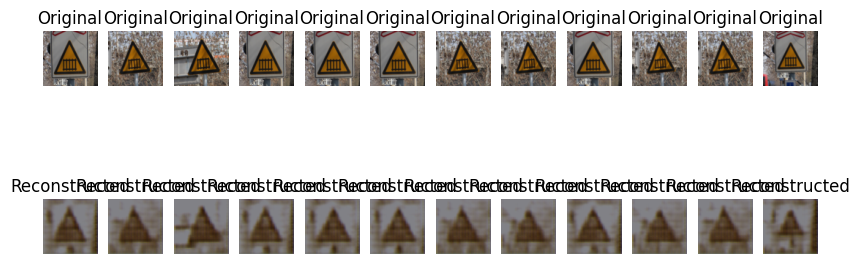

Class: 50, Epoch 132/500, Train Loss: 0.0136, Valid Loss: 0.0124
Class: 50, Epoch 133/500, Train Loss: 0.0136, Valid Loss: 0.0124
Class: 50, Epoch 134/500, Train Loss: 0.0136, Valid Loss: 0.0124
Class: 50, Epoch 135/500, Train Loss: 0.0136, Valid Loss: 0.0124
Class: 50, Epoch 136/500, Train Loss: 0.0135, Valid Loss: 0.0123
Class: 50, Epoch 137/500, Train Loss: 0.0135, Valid Loss: 0.0123
Class: 50, Epoch 138/500, Train Loss: 0.0135, Valid Loss: 0.0122
Class: 50, Epoch 139/500, Train Loss: 0.0135, Valid Loss: 0.0123
Class: 50, Epoch 140/500, Train Loss: 0.0134, Valid Loss: 0.0122
Class: 50, Epoch 141/500, Train Loss: 0.0134, Valid Loss: 0.0123


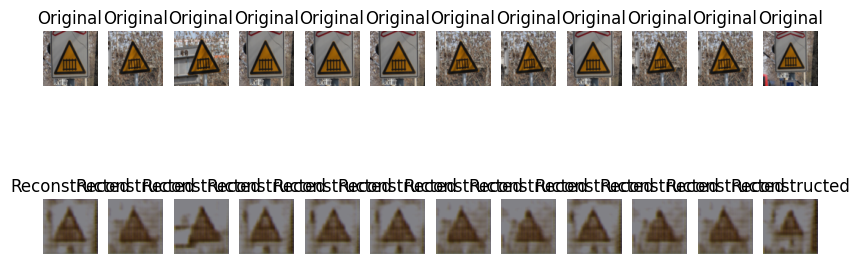

Class: 50, Epoch 142/500, Train Loss: 0.0134, Valid Loss: 0.0122
Class: 50, Epoch 143/500, Train Loss: 0.0135, Valid Loss: 0.0124
Class: 50, Epoch 144/500, Train Loss: 0.0135, Valid Loss: 0.0123
Class: 50, Epoch 145/500, Train Loss: 0.0137, Valid Loss: 0.0127
Class: 50, Epoch 146/500, Train Loss: 0.0138, Valid Loss: 0.0122
Class: 50, Epoch 147/500, Train Loss: 0.0134, Valid Loss: 0.0121
Class: 50, Epoch 148/500, Train Loss: 0.0133, Valid Loss: 0.0122
Class: 50, Epoch 149/500, Train Loss: 0.0133, Valid Loss: 0.0120
Class: 50, Epoch 150/500, Train Loss: 0.0133, Valid Loss: 0.0121
Class: 50, Epoch 151/500, Train Loss: 0.0132, Valid Loss: 0.0120


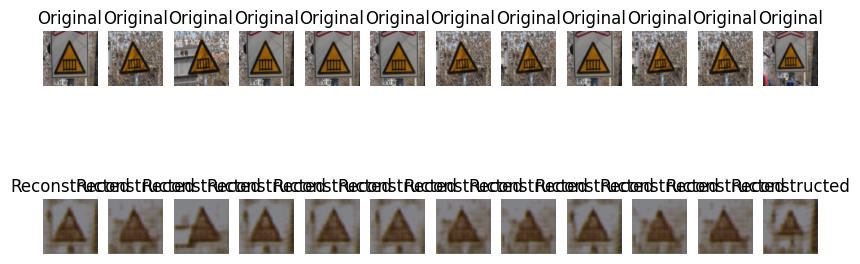

Class: 50, Epoch 152/500, Train Loss: 0.0132, Valid Loss: 0.0120
Class: 50, Epoch 153/500, Train Loss: 0.0132, Valid Loss: 0.0120
Class: 50, Epoch 154/500, Train Loss: 0.0132, Valid Loss: 0.0120
Class: 50, Epoch 155/500, Train Loss: 0.0131, Valid Loss: 0.0119
Class: 50, Epoch 156/500, Train Loss: 0.0131, Valid Loss: 0.0119
Class: 50, Epoch 157/500, Train Loss: 0.0131, Valid Loss: 0.0119
Class: 50, Epoch 158/500, Train Loss: 0.0131, Valid Loss: 0.0118
Class: 50, Epoch 159/500, Train Loss: 0.0130, Valid Loss: 0.0119
Class: 50, Epoch 160/500, Train Loss: 0.0130, Valid Loss: 0.0118
Class: 50, Epoch 161/500, Train Loss: 0.0130, Valid Loss: 0.0118


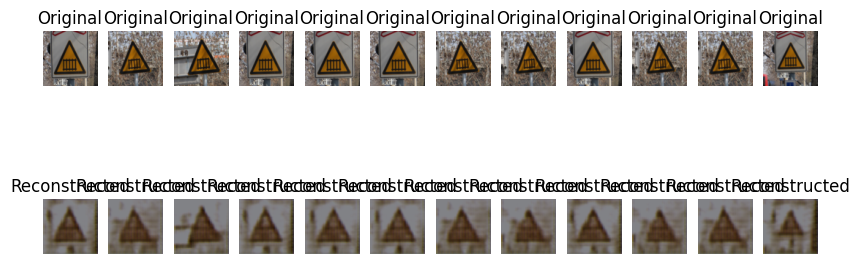

Class: 50, Epoch 162/500, Train Loss: 0.0130, Valid Loss: 0.0118
Class: 50, Epoch 163/500, Train Loss: 0.0129, Valid Loss: 0.0117
Class: 50, Epoch 164/500, Train Loss: 0.0129, Valid Loss: 0.0117
Class: 50, Epoch 165/500, Train Loss: 0.0129, Valid Loss: 0.0117
Class: 50, Epoch 166/500, Train Loss: 0.0129, Valid Loss: 0.0117
Class: 50, Epoch 167/500, Train Loss: 0.0129, Valid Loss: 0.0117
Class: 50, Epoch 168/500, Train Loss: 0.0128, Valid Loss: 0.0116
Class: 50, Epoch 169/500, Train Loss: 0.0128, Valid Loss: 0.0117
Class: 50, Epoch 170/500, Train Loss: 0.0128, Valid Loss: 0.0116
Class: 50, Epoch 171/500, Train Loss: 0.0128, Valid Loss: 0.0118


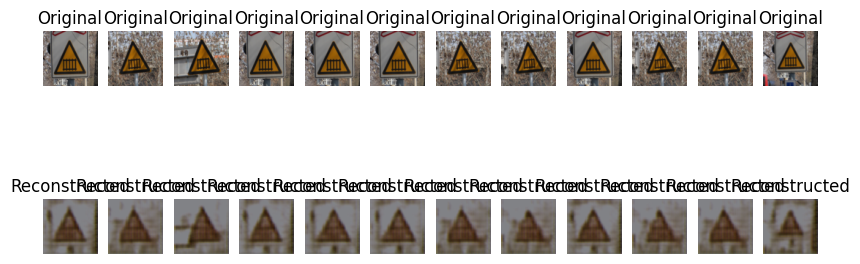

Class: 50, Epoch 172/500, Train Loss: 0.0128, Valid Loss: 0.0116
Class: 50, Epoch 173/500, Train Loss: 0.0128, Valid Loss: 0.0117
Class: 50, Epoch 174/500, Train Loss: 0.0128, Valid Loss: 0.0115
Class: 50, Epoch 175/500, Train Loss: 0.0128, Valid Loss: 0.0117
Class: 50, Epoch 176/500, Train Loss: 0.0128, Valid Loss: 0.0114
Class: 50, Epoch 177/500, Train Loss: 0.0127, Valid Loss: 0.0116
Class: 50, Epoch 178/500, Train Loss: 0.0126, Valid Loss: 0.0114
Class: 50, Epoch 179/500, Train Loss: 0.0126, Valid Loss: 0.0114
Class: 50, Epoch 180/500, Train Loss: 0.0126, Valid Loss: 0.0114
Class: 50, Epoch 181/500, Train Loss: 0.0125, Valid Loss: 0.0113


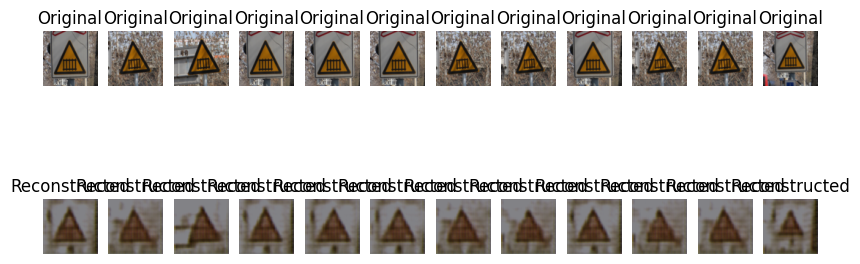

Class: 50, Epoch 182/500, Train Loss: 0.0125, Valid Loss: 0.0116
Class: 50, Epoch 183/500, Train Loss: 0.0126, Valid Loss: 0.0113
Class: 50, Epoch 184/500, Train Loss: 0.0126, Valid Loss: 0.0116
Class: 50, Epoch 185/500, Train Loss: 0.0126, Valid Loss: 0.0113
Class: 50, Epoch 186/500, Train Loss: 0.0125, Valid Loss: 0.0113
Class: 50, Epoch 187/500, Train Loss: 0.0124, Valid Loss: 0.0112
Class: 50, Epoch 188/500, Train Loss: 0.0124, Valid Loss: 0.0112
Class: 50, Epoch 189/500, Train Loss: 0.0125, Valid Loss: 0.0116
Class: 50, Epoch 190/500, Train Loss: 0.0126, Valid Loss: 0.0112
Class: 50, Epoch 191/500, Train Loss: 0.0125, Valid Loss: 0.0112


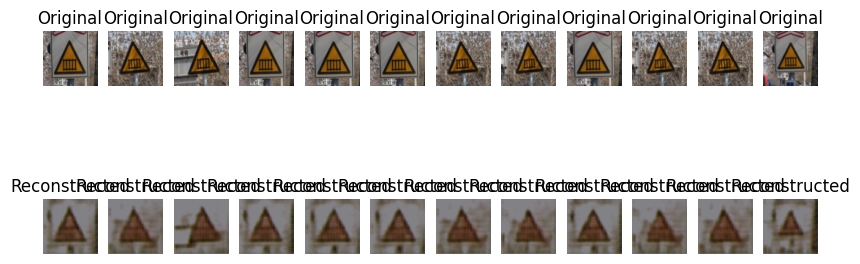

Class: 50, Epoch 192/500, Train Loss: 0.0123, Valid Loss: 0.0112
Class: 50, Epoch 193/500, Train Loss: 0.0122, Valid Loss: 0.0111
Class: 50, Epoch 194/500, Train Loss: 0.0123, Valid Loss: 0.0113
Class: 50, Epoch 195/500, Train Loss: 0.0123, Valid Loss: 0.0110
Class: 50, Epoch 196/500, Train Loss: 0.0122, Valid Loss: 0.0110
Class: 50, Epoch 197/500, Train Loss: 0.0122, Valid Loss: 0.0111
Class: 50, Epoch 198/500, Train Loss: 0.0122, Valid Loss: 0.0109
Class: 50, Epoch 199/500, Train Loss: 0.0122, Valid Loss: 0.0110
Class: 50, Epoch 200/500, Train Loss: 0.0121, Valid Loss: 0.0109
Class: 50, Epoch 201/500, Train Loss: 0.0120, Valid Loss: 0.0108


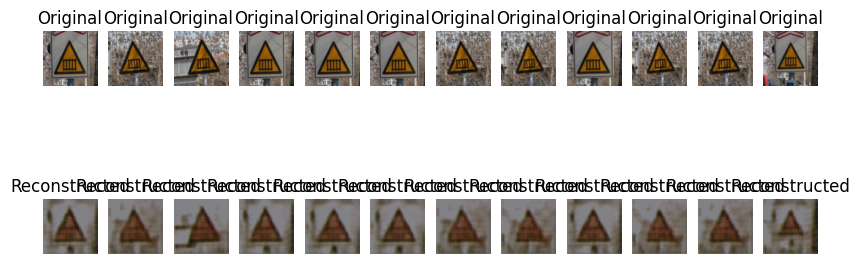

Class: 50, Epoch 202/500, Train Loss: 0.0120, Valid Loss: 0.0110
Class: 50, Epoch 203/500, Train Loss: 0.0121, Valid Loss: 0.0109
Class: 50, Epoch 204/500, Train Loss: 0.0122, Valid Loss: 0.0111
Class: 50, Epoch 205/500, Train Loss: 0.0122, Valid Loss: 0.0108
Class: 50, Epoch 206/500, Train Loss: 0.0120, Valid Loss: 0.0107
Class: 50, Epoch 207/500, Train Loss: 0.0119, Valid Loss: 0.0108
Class: 50, Epoch 208/500, Train Loss: 0.0120, Valid Loss: 0.0107
Class: 50, Epoch 209/500, Train Loss: 0.0120, Valid Loss: 0.0108
Class: 50, Epoch 210/500, Train Loss: 0.0119, Valid Loss: 0.0106
Class: 50, Epoch 211/500, Train Loss: 0.0118, Valid Loss: 0.0106


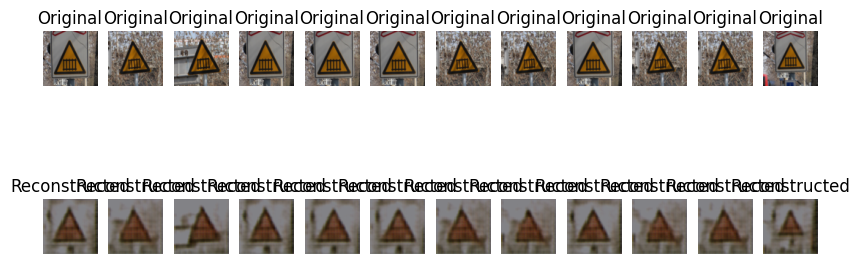

Class: 50, Epoch 212/500, Train Loss: 0.0118, Valid Loss: 0.0107
Class: 50, Epoch 213/500, Train Loss: 0.0118, Valid Loss: 0.0106
Class: 50, Epoch 214/500, Train Loss: 0.0118, Valid Loss: 0.0106
Class: 50, Epoch 215/500, Train Loss: 0.0117, Valid Loss: 0.0105
Class: 50, Epoch 216/500, Train Loss: 0.0117, Valid Loss: 0.0105
Class: 50, Epoch 217/500, Train Loss: 0.0117, Valid Loss: 0.0107
Class: 50, Epoch 218/500, Train Loss: 0.0118, Valid Loss: 0.0105
Class: 50, Epoch 219/500, Train Loss: 0.0118, Valid Loss: 0.0105
Class: 50, Epoch 220/500, Train Loss: 0.0116, Valid Loss: 0.0104
Class: 50, Epoch 221/500, Train Loss: 0.0115, Valid Loss: 0.0104


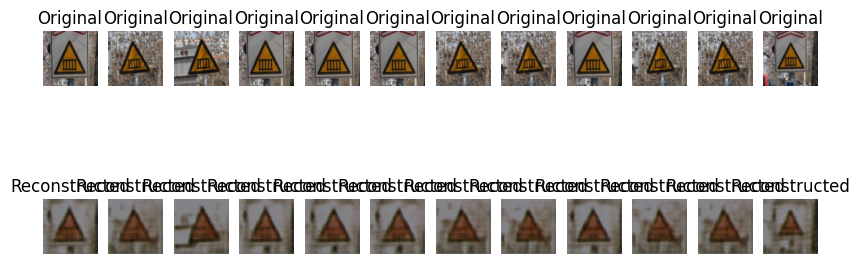

Class: 50, Epoch 222/500, Train Loss: 0.0117, Valid Loss: 0.0108
Class: 50, Epoch 223/500, Train Loss: 0.0118, Valid Loss: 0.0104
Class: 50, Epoch 224/500, Train Loss: 0.0116, Valid Loss: 0.0103
Class: 50, Epoch 225/500, Train Loss: 0.0115, Valid Loss: 0.0104
Class: 50, Epoch 226/500, Train Loss: 0.0115, Valid Loss: 0.0103
Class: 50, Epoch 227/500, Train Loss: 0.0115, Valid Loss: 0.0104
Class: 50, Epoch 228/500, Train Loss: 0.0115, Valid Loss: 0.0103
Class: 50, Epoch 229/500, Train Loss: 0.0114, Valid Loss: 0.0102
Class: 50, Epoch 230/500, Train Loss: 0.0115, Valid Loss: 0.0104
Class: 50, Epoch 231/500, Train Loss: 0.0115, Valid Loss: 0.0101


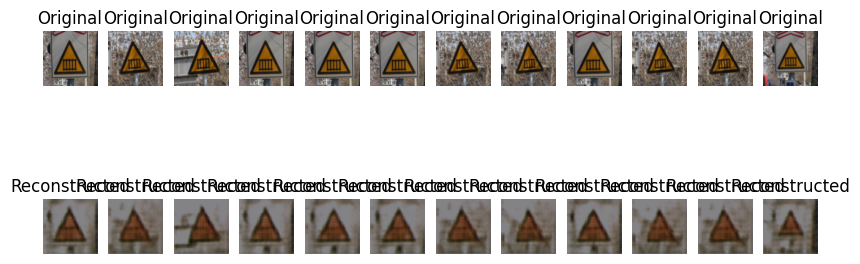

Class: 50, Epoch 232/500, Train Loss: 0.0113, Valid Loss: 0.0101
Class: 50, Epoch 233/500, Train Loss: 0.0113, Valid Loss: 0.0104
Class: 50, Epoch 234/500, Train Loss: 0.0114, Valid Loss: 0.0101
Class: 50, Epoch 235/500, Train Loss: 0.0113, Valid Loss: 0.0100
Class: 50, Epoch 236/500, Train Loss: 0.0112, Valid Loss: 0.0102
Class: 50, Epoch 237/500, Train Loss: 0.0113, Valid Loss: 0.0100
Class: 50, Epoch 238/500, Train Loss: 0.0112, Valid Loss: 0.0100
Class: 50, Epoch 239/500, Train Loss: 0.0111, Valid Loss: 0.0100
Class: 50, Epoch 240/500, Train Loss: 0.0111, Valid Loss: 0.0099
Class: 50, Epoch 241/500, Train Loss: 0.0111, Valid Loss: 0.0099


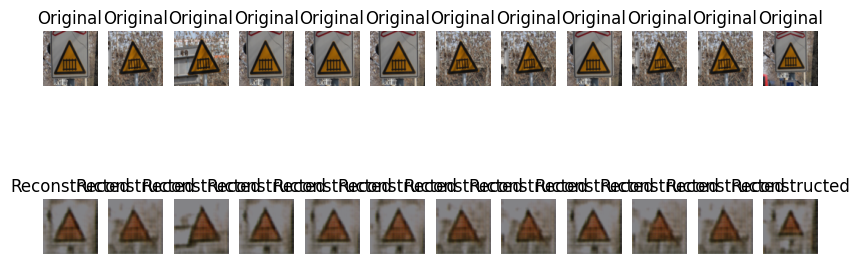

Class: 50, Epoch 242/500, Train Loss: 0.0110, Valid Loss: 0.0099
Class: 50, Epoch 243/500, Train Loss: 0.0111, Valid Loss: 0.0099
Class: 50, Epoch 244/500, Train Loss: 0.0110, Valid Loss: 0.0099
Class: 50, Epoch 245/500, Train Loss: 0.0110, Valid Loss: 0.0098
Class: 50, Epoch 246/500, Train Loss: 0.0110, Valid Loss: 0.0098
Class: 50, Epoch 247/500, Train Loss: 0.0109, Valid Loss: 0.0099
Class: 50, Epoch 248/500, Train Loss: 0.0110, Valid Loss: 0.0097
Class: 50, Epoch 249/500, Train Loss: 0.0109, Valid Loss: 0.0097
Class: 50, Epoch 250/500, Train Loss: 0.0109, Valid Loss: 0.0098
Class: 50, Epoch 251/500, Train Loss: 0.0108, Valid Loss: 0.0097


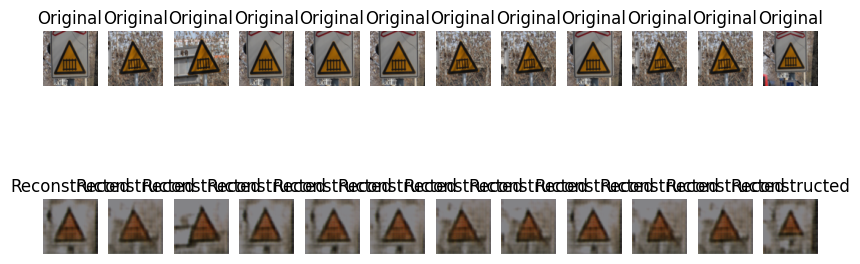

Class: 50, Epoch 252/500, Train Loss: 0.0109, Valid Loss: 0.0098
Class: 50, Epoch 253/500, Train Loss: 0.0109, Valid Loss: 0.0097
Class: 50, Epoch 254/500, Train Loss: 0.0109, Valid Loss: 0.0099
Class: 50, Epoch 255/500, Train Loss: 0.0109, Valid Loss: 0.0096
Class: 50, Epoch 256/500, Train Loss: 0.0108, Valid Loss: 0.0096
Class: 50, Epoch 257/500, Train Loss: 0.0107, Valid Loss: 0.0096
Class: 50, Epoch 258/500, Train Loss: 0.0107, Valid Loss: 0.0095
Class: 50, Epoch 259/500, Train Loss: 0.0107, Valid Loss: 0.0097
Class: 50, Epoch 260/500, Train Loss: 0.0107, Valid Loss: 0.0095
Class: 50, Epoch 261/500, Train Loss: 0.0107, Valid Loss: 0.0096


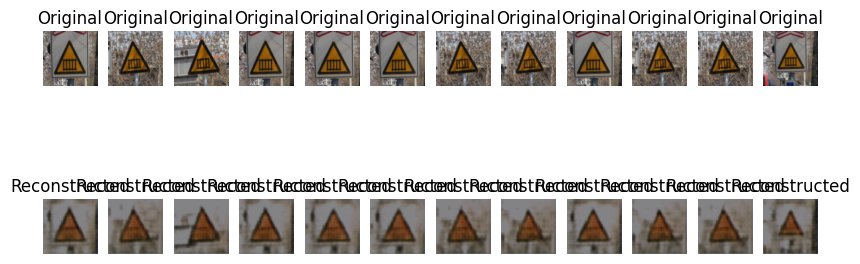

Class: 50, Epoch 262/500, Train Loss: 0.0107, Valid Loss: 0.0094
Class: 50, Epoch 263/500, Train Loss: 0.0106, Valid Loss: 0.0095
Class: 50, Epoch 264/500, Train Loss: 0.0106, Valid Loss: 0.0095
Class: 50, Epoch 265/500, Train Loss: 0.0106, Valid Loss: 0.0094
Class: 50, Epoch 266/500, Train Loss: 0.0105, Valid Loss: 0.0094
Class: 50, Epoch 267/500, Train Loss: 0.0105, Valid Loss: 0.0093
Class: 50, Epoch 268/500, Train Loss: 0.0105, Valid Loss: 0.0094
Class: 50, Epoch 269/500, Train Loss: 0.0105, Valid Loss: 0.0093
Class: 50, Epoch 270/500, Train Loss: 0.0105, Valid Loss: 0.0093
Class: 50, Epoch 271/500, Train Loss: 0.0105, Valid Loss: 0.0094


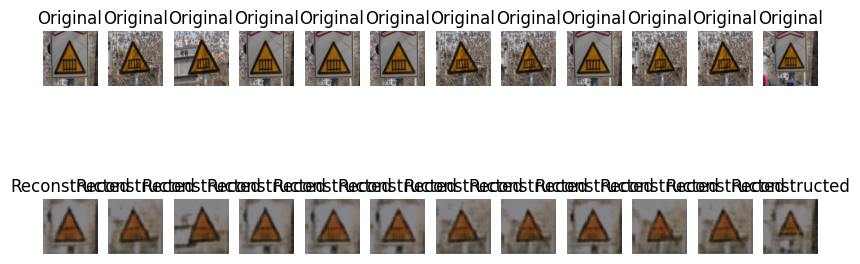

Class: 50, Epoch 272/500, Train Loss: 0.0105, Valid Loss: 0.0093
Class: 50, Epoch 273/500, Train Loss: 0.0105, Valid Loss: 0.0097
Class: 50, Epoch 274/500, Train Loss: 0.0107, Valid Loss: 0.0094
Class: 50, Epoch 275/500, Train Loss: 0.0107, Valid Loss: 0.0095
Class: 50, Epoch 276/500, Train Loss: 0.0106, Valid Loss: 0.0092
Class: 50, Epoch 277/500, Train Loss: 0.0104, Valid Loss: 0.0092
Class: 50, Epoch 278/500, Train Loss: 0.0104, Valid Loss: 0.0094
Class: 50, Epoch 279/500, Train Loss: 0.0105, Valid Loss: 0.0092
Class: 50, Epoch 280/500, Train Loss: 0.0104, Valid Loss: 0.0092
Class: 50, Epoch 281/500, Train Loss: 0.0103, Valid Loss: 0.0092


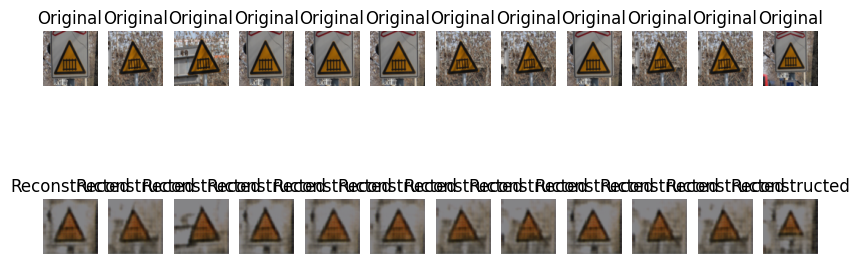

Class: 50, Epoch 282/500, Train Loss: 0.0103, Valid Loss: 0.0091
Class: 50, Epoch 283/500, Train Loss: 0.0103, Valid Loss: 0.0093
Class: 50, Epoch 284/500, Train Loss: 0.0103, Valid Loss: 0.0091
Class: 50, Epoch 285/500, Train Loss: 0.0103, Valid Loss: 0.0091
Class: 50, Epoch 286/500, Train Loss: 0.0102, Valid Loss: 0.0092
Class: 50, Epoch 287/500, Train Loss: 0.0103, Valid Loss: 0.0091
Class: 50, Epoch 288/500, Train Loss: 0.0103, Valid Loss: 0.0091
Class: 50, Epoch 289/500, Train Loss: 0.0102, Valid Loss: 0.0091
Class: 50, Epoch 290/500, Train Loss: 0.0102, Valid Loss: 0.0090
Class: 50, Epoch 291/500, Train Loss: 0.0102, Valid Loss: 0.0091


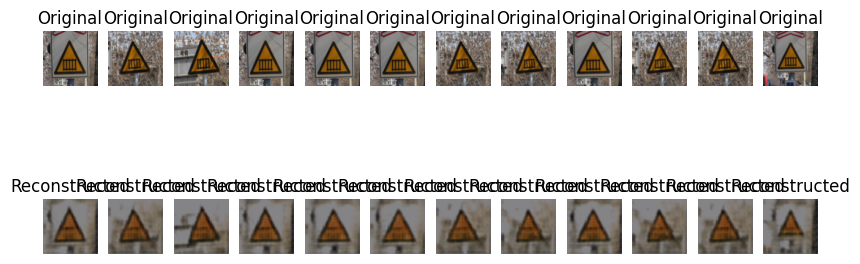

Class: 50, Epoch 292/500, Train Loss: 0.0101, Valid Loss: 0.0090
Class: 50, Epoch 293/500, Train Loss: 0.0102, Valid Loss: 0.0090
Class: 50, Epoch 294/500, Train Loss: 0.0102, Valid Loss: 0.0089
Class: 50, Epoch 295/500, Train Loss: 0.0101, Valid Loss: 0.0090
Class: 50, Epoch 296/500, Train Loss: 0.0101, Valid Loss: 0.0090
Class: 50, Epoch 297/500, Train Loss: 0.0101, Valid Loss: 0.0089
Class: 50, Epoch 298/500, Train Loss: 0.0101, Valid Loss: 0.0089
Class: 50, Epoch 299/500, Train Loss: 0.0101, Valid Loss: 0.0089
Class: 50, Epoch 300/500, Train Loss: 0.0100, Valid Loss: 0.0090
Class: 50, Epoch 301/500, Train Loss: 0.0100, Valid Loss: 0.0089


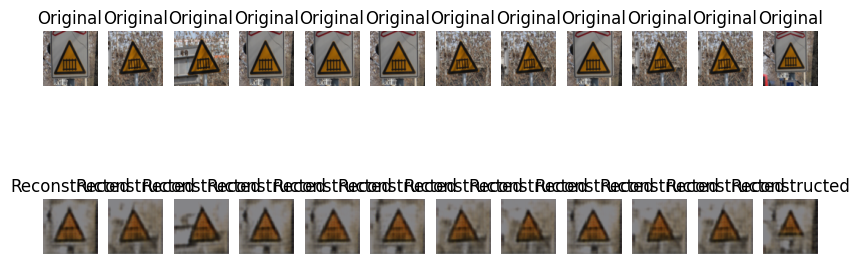

Class: 50, Epoch 302/500, Train Loss: 0.0100, Valid Loss: 0.0089
Class: 50, Epoch 303/500, Train Loss: 0.0100, Valid Loss: 0.0088
Class: 50, Epoch 304/500, Train Loss: 0.0100, Valid Loss: 0.0088
Class: 50, Epoch 305/500, Train Loss: 0.0100, Valid Loss: 0.0088
Class: 50, Epoch 306/500, Train Loss: 0.0099, Valid Loss: 0.0088
Class: 50, Epoch 307/500, Train Loss: 0.0100, Valid Loss: 0.0088
Class: 50, Epoch 308/500, Train Loss: 0.0099, Valid Loss: 0.0088
Class: 50, Epoch 309/500, Train Loss: 0.0100, Valid Loss: 0.0088
Class: 50, Epoch 310/500, Train Loss: 0.0100, Valid Loss: 0.0089
Class: 50, Epoch 311/500, Train Loss: 0.0100, Valid Loss: 0.0089


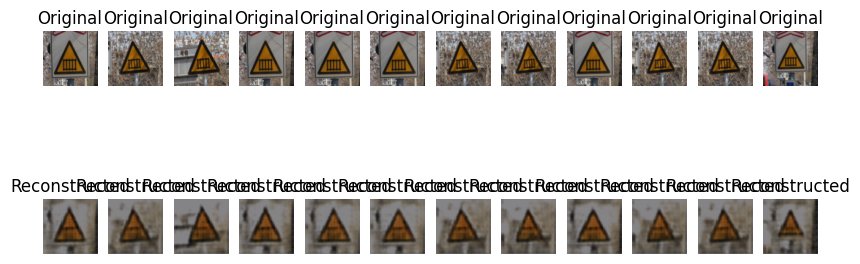

Class: 50, Epoch 312/500, Train Loss: 0.0101, Valid Loss: 0.0095
Class: 50, Epoch 313/500, Train Loss: 0.0105, Valid Loss: 0.0090
Class: 50, Epoch 314/500, Train Loss: 0.0103, Valid Loss: 0.0090
Class: 50, Epoch 315/500, Train Loss: 0.0101, Valid Loss: 0.0088
Class: 50, Epoch 316/500, Train Loss: 0.0099, Valid Loss: 0.0088
Class: 50, Epoch 317/500, Train Loss: 0.0100, Valid Loss: 0.0091
Class: 50, Epoch 318/500, Train Loss: 0.0101, Valid Loss: 0.0087
Class: 50, Epoch 319/500, Train Loss: 0.0099, Valid Loss: 0.0088
Class: 50, Epoch 320/500, Train Loss: 0.0100, Valid Loss: 0.0092
Class: 50, Epoch 321/500, Train Loss: 0.0101, Valid Loss: 0.0087


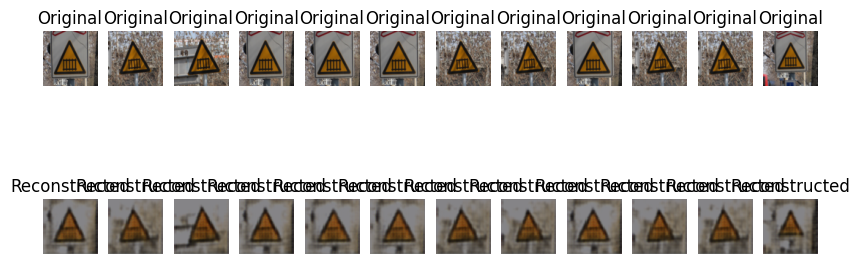

Class: 50, Epoch 322/500, Train Loss: 0.0099, Valid Loss: 0.0088
Class: 50, Epoch 323/500, Train Loss: 0.0101, Valid Loss: 0.0091
Class: 50, Epoch 324/500, Train Loss: 0.0102, Valid Loss: 0.0087
Class: 50, Epoch 325/500, Train Loss: 0.0098, Valid Loss: 0.0088
Class: 50, Epoch 326/500, Train Loss: 0.0101, Valid Loss: 0.0090
Class: 50, Epoch 327/500, Train Loss: 0.0100, Valid Loss: 0.0088
Class: 50, Epoch 328/500, Train Loss: 0.0098, Valid Loss: 0.0088
Class: 50, Epoch 329/500, Train Loss: 0.0100, Valid Loss: 0.0087
Class: 50, Epoch 330/500, Train Loss: 0.0098, Valid Loss: 0.0089
Class: 50, Epoch 331/500, Train Loss: 0.0099, Valid Loss: 0.0086


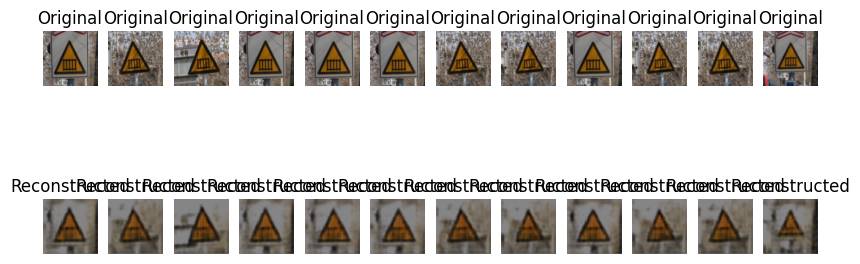

Class: 50, Epoch 332/500, Train Loss: 0.0099, Valid Loss: 0.0086
Class: 50, Epoch 333/500, Train Loss: 0.0098, Valid Loss: 0.0087
Class: 50, Epoch 334/500, Train Loss: 0.0098, Valid Loss: 0.0086
Class: 50, Epoch 335/500, Train Loss: 0.0097, Valid Loss: 0.0086
Class: 50, Epoch 336/500, Train Loss: 0.0097, Valid Loss: 0.0086
Class: 50, Epoch 337/500, Train Loss: 0.0097, Valid Loss: 0.0086
Class: 50, Epoch 338/500, Train Loss: 0.0097, Valid Loss: 0.0085
Class: 50, Epoch 339/500, Train Loss: 0.0097, Valid Loss: 0.0086
Class: 50, Epoch 340/500, Train Loss: 0.0096, Valid Loss: 0.0085
Class: 50, Epoch 341/500, Train Loss: 0.0097, Valid Loss: 0.0085


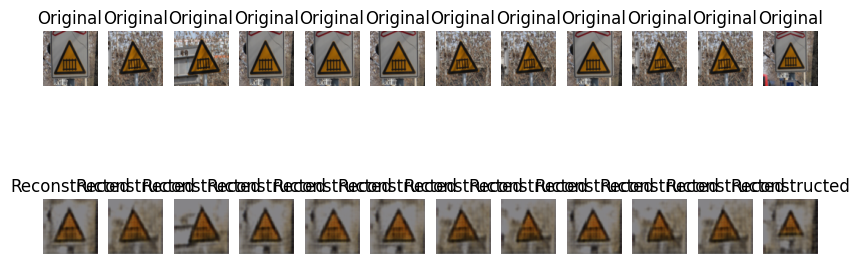

Class: 50, Epoch 342/500, Train Loss: 0.0097, Valid Loss: 0.0085
Class: 50, Epoch 343/500, Train Loss: 0.0096, Valid Loss: 0.0085
Class: 50, Epoch 344/500, Train Loss: 0.0096, Valid Loss: 0.0085
Class: 50, Epoch 345/500, Train Loss: 0.0097, Valid Loss: 0.0085
Class: 50, Epoch 346/500, Train Loss: 0.0096, Valid Loss: 0.0085
Class: 50, Epoch 347/500, Train Loss: 0.0096, Valid Loss: 0.0084
Class: 50, Epoch 348/500, Train Loss: 0.0096, Valid Loss: 0.0085
Class: 50, Epoch 349/500, Train Loss: 0.0096, Valid Loss: 0.0085
Class: 50, Epoch 350/500, Train Loss: 0.0096, Valid Loss: 0.0084
Class: 50, Epoch 351/500, Train Loss: 0.0096, Valid Loss: 0.0084


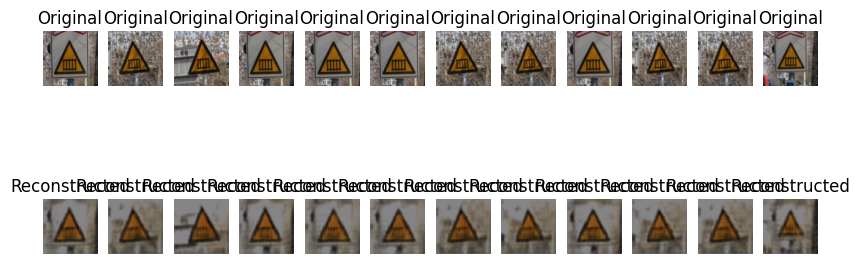

Class: 50, Epoch 352/500, Train Loss: 0.0095, Valid Loss: 0.0085
Class: 50, Epoch 353/500, Train Loss: 0.0096, Valid Loss: 0.0084
Class: 50, Epoch 354/500, Train Loss: 0.0095, Valid Loss: 0.0084
Class: 50, Epoch 355/500, Train Loss: 0.0095, Valid Loss: 0.0084
Class: 50, Epoch 356/500, Train Loss: 0.0095, Valid Loss: 0.0084
Class: 50, Epoch 357/500, Train Loss: 0.0095, Valid Loss: 0.0084
Class: 50, Epoch 358/500, Train Loss: 0.0095, Valid Loss: 0.0084
Class: 50, Epoch 359/500, Train Loss: 0.0095, Valid Loss: 0.0084
Class: 50, Epoch 360/500, Train Loss: 0.0095, Valid Loss: 0.0083
Class: 50, Epoch 361/500, Train Loss: 0.0095, Valid Loss: 0.0084


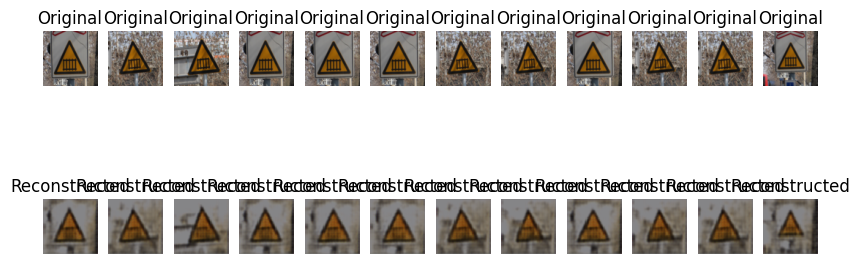

Class: 50, Epoch 362/500, Train Loss: 0.0095, Valid Loss: 0.0083
Class: 50, Epoch 363/500, Train Loss: 0.0095, Valid Loss: 0.0083
Class: 50, Epoch 364/500, Train Loss: 0.0095, Valid Loss: 0.0083
Class: 50, Epoch 365/500, Train Loss: 0.0095, Valid Loss: 0.0083
Class: 50, Epoch 366/500, Train Loss: 0.0094, Valid Loss: 0.0083
Class: 50, Epoch 367/500, Train Loss: 0.0094, Valid Loss: 0.0083
Class: 50, Epoch 368/500, Train Loss: 0.0094, Valid Loss: 0.0083
Class: 50, Epoch 369/500, Train Loss: 0.0094, Valid Loss: 0.0083
Class: 50, Epoch 370/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 371/500, Train Loss: 0.0094, Valid Loss: 0.0083


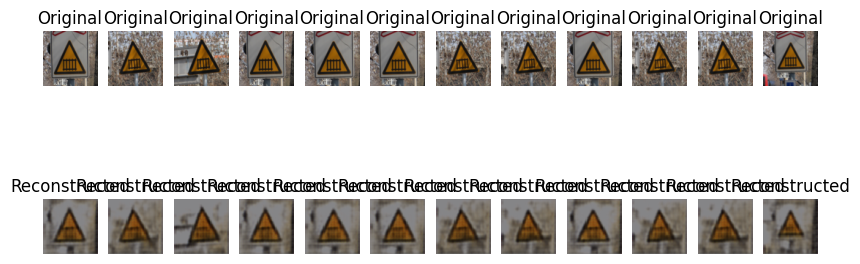

Class: 50, Epoch 372/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 373/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 374/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 375/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 376/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 377/500, Train Loss: 0.0094, Valid Loss: 0.0083
Class: 50, Epoch 378/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 379/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 380/500, Train Loss: 0.0093, Valid Loss: 0.0082
Class: 50, Epoch 381/500, Train Loss: 0.0093, Valid Loss: 0.0082


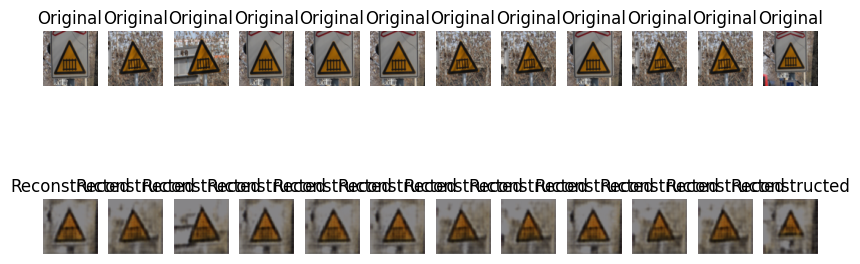

Class: 50, Epoch 382/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 383/500, Train Loss: 0.0094, Valid Loss: 0.0082
Class: 50, Epoch 384/500, Train Loss: 0.0093, Valid Loss: 0.0082
Class: 50, Epoch 385/500, Train Loss: 0.0093, Valid Loss: 0.0081
Class: 50, Epoch 386/500, Train Loss: 0.0093, Valid Loss: 0.0082
Class: 50, Epoch 387/500, Train Loss: 0.0093, Valid Loss: 0.0081
Class: 50, Epoch 388/500, Train Loss: 0.0093, Valid Loss: 0.0081
Class: 50, Epoch 389/500, Train Loss: 0.0093, Valid Loss: 0.0081
Class: 50, Epoch 390/500, Train Loss: 0.0093, Valid Loss: 0.0081
Class: 50, Epoch 391/500, Train Loss: 0.0092, Valid Loss: 0.0081


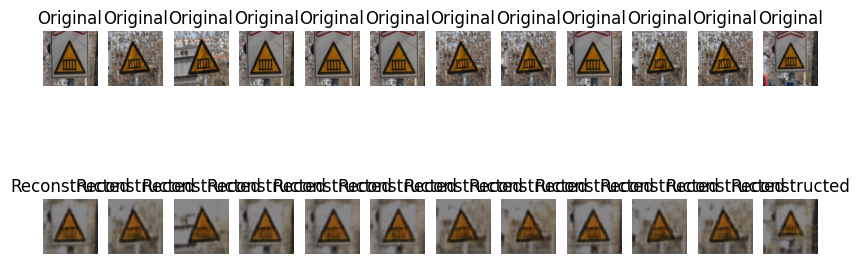

Class: 50, Epoch 392/500, Train Loss: 0.0093, Valid Loss: 0.0082
Class: 50, Epoch 393/500, Train Loss: 0.0093, Valid Loss: 0.0081
Class: 50, Epoch 394/500, Train Loss: 0.0092, Valid Loss: 0.0081
Class: 50, Epoch 395/500, Train Loss: 0.0092, Valid Loss: 0.0081
Class: 50, Epoch 396/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 397/500, Train Loss: 0.0092, Valid Loss: 0.0081
Class: 50, Epoch 398/500, Train Loss: 0.0092, Valid Loss: 0.0081
Class: 50, Epoch 399/500, Train Loss: 0.0092, Valid Loss: 0.0081
Class: 50, Epoch 400/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 401/500, Train Loss: 0.0092, Valid Loss: 0.0081


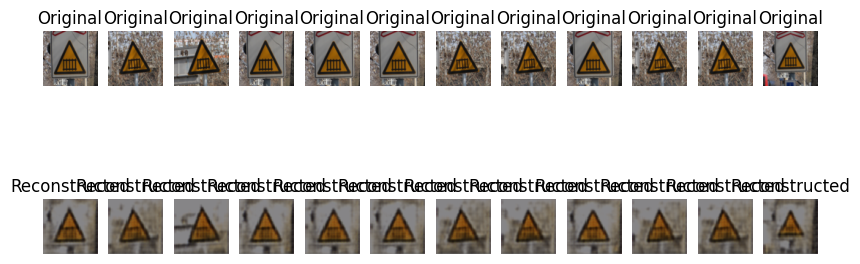

Class: 50, Epoch 402/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 403/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 404/500, Train Loss: 0.0092, Valid Loss: 0.0081
Class: 50, Epoch 405/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 406/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 407/500, Train Loss: 0.0091, Valid Loss: 0.0081
Class: 50, Epoch 408/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 409/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 410/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 411/500, Train Loss: 0.0091, Valid Loss: 0.0080


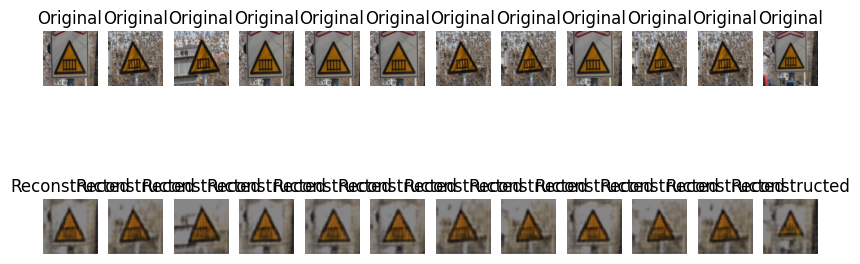

Class: 50, Epoch 412/500, Train Loss: 0.0092, Valid Loss: 0.0080
Class: 50, Epoch 413/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 414/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 415/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 416/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 417/500, Train Loss: 0.0091, Valid Loss: 0.0079
Class: 50, Epoch 418/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 419/500, Train Loss: 0.0091, Valid Loss: 0.0079
Class: 50, Epoch 420/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 421/500, Train Loss: 0.0091, Valid Loss: 0.0079


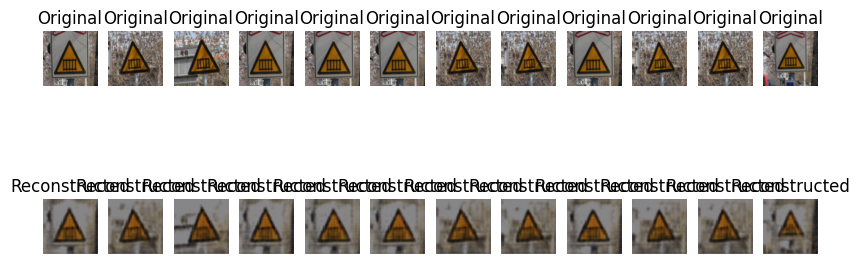

Class: 50, Epoch 422/500, Train Loss: 0.0091, Valid Loss: 0.0079
Class: 50, Epoch 423/500, Train Loss: 0.0091, Valid Loss: 0.0079
Class: 50, Epoch 424/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 425/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 426/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 427/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 428/500, Train Loss: 0.0091, Valid Loss: 0.0079
Class: 50, Epoch 429/500, Train Loss: 0.0091, Valid Loss: 0.0080
Class: 50, Epoch 430/500, Train Loss: 0.0091, Valid Loss: 0.0078
Class: 50, Epoch 431/500, Train Loss: 0.0090, Valid Loss: 0.0078


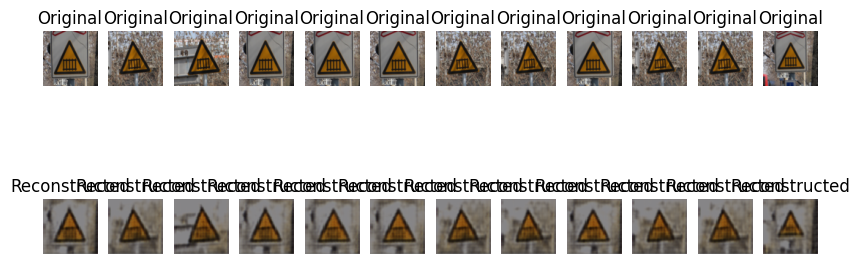

Class: 50, Epoch 432/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 433/500, Train Loss: 0.0090, Valid Loss: 0.0078
Class: 50, Epoch 434/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 435/500, Train Loss: 0.0090, Valid Loss: 0.0078
Class: 50, Epoch 436/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 437/500, Train Loss: 0.0090, Valid Loss: 0.0078
Class: 50, Epoch 438/500, Train Loss: 0.0090, Valid Loss: 0.0078
Class: 50, Epoch 439/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 440/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 441/500, Train Loss: 0.0089, Valid Loss: 0.0078


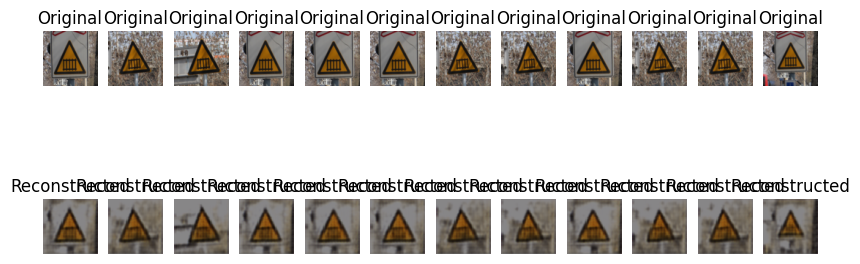

Class: 50, Epoch 442/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 443/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 444/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 445/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 446/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 447/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 448/500, Train Loss: 0.0089, Valid Loss: 0.0079
Class: 50, Epoch 449/500, Train Loss: 0.0090, Valid Loss: 0.0078
Class: 50, Epoch 450/500, Train Loss: 0.0090, Valid Loss: 0.0079
Class: 50, Epoch 451/500, Train Loss: 0.0090, Valid Loss: 0.0077


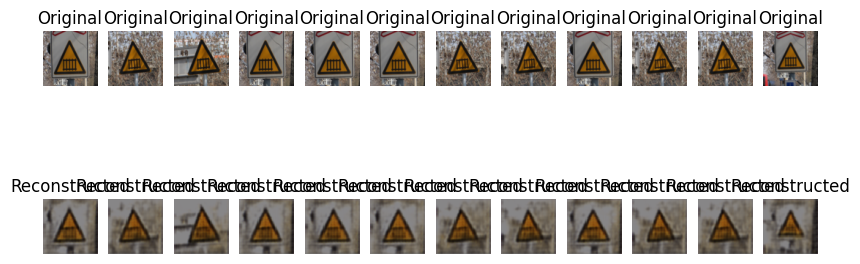

Class: 50, Epoch 452/500, Train Loss: 0.0090, Valid Loss: 0.0078
Class: 50, Epoch 453/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 454/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 455/500, Train Loss: 0.0089, Valid Loss: 0.0078
Class: 50, Epoch 456/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 457/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 458/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 459/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 460/500, Train Loss: 0.0089, Valid Loss: 0.0077
Class: 50, Epoch 461/500, Train Loss: 0.0089, Valid Loss: 0.0077


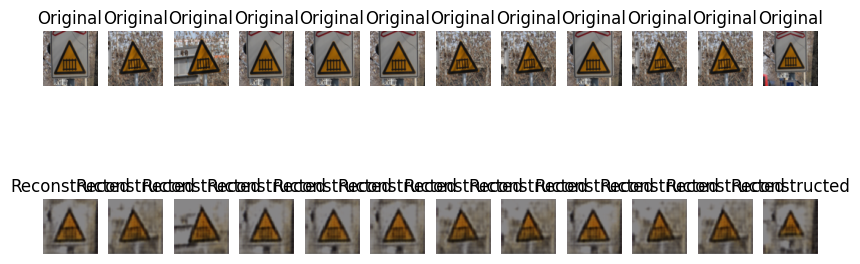

Class: 50, Epoch 462/500, Train Loss: 0.0088, Valid Loss: 0.0077
Class: 50, Epoch 463/500, Train Loss: 0.0088, Valid Loss: 0.0077
Class: 50, Epoch 464/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 465/500, Train Loss: 0.0088, Valid Loss: 0.0077
Class: 50, Epoch 466/500, Train Loss: 0.0089, Valid Loss: 0.0076
Class: 50, Epoch 467/500, Train Loss: 0.0088, Valid Loss: 0.0077
Class: 50, Epoch 468/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 469/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 470/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 471/500, Train Loss: 0.0088, Valid Loss: 0.0076


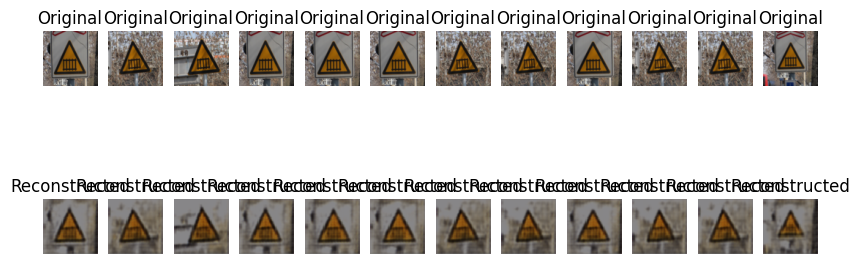

Class: 50, Epoch 472/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 473/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 474/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 475/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 476/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 477/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 478/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 479/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 480/500, Train Loss: 0.0088, Valid Loss: 0.0076
Class: 50, Epoch 481/500, Train Loss: 0.0088, Valid Loss: 0.0076


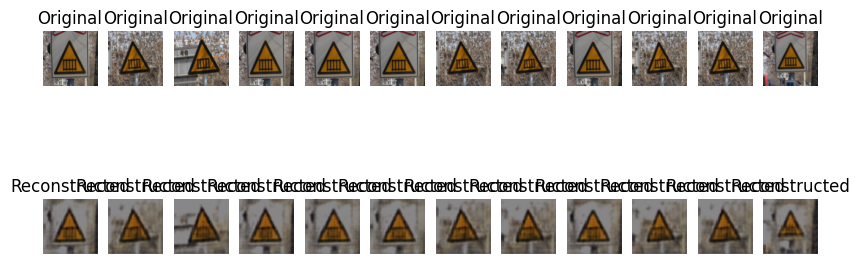

Class: 50, Epoch 482/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 483/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 484/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 485/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 486/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 487/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 488/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 489/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 490/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 491/500, Train Loss: 0.0087, Valid Loss: 0.0076


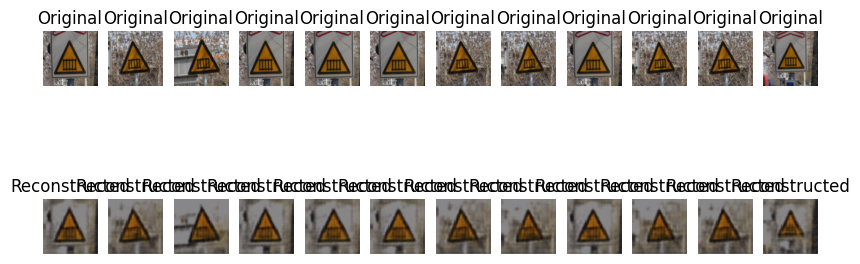

Class: 50, Epoch 492/500, Train Loss: 0.0088, Valid Loss: 0.0077
Class: 50, Epoch 493/500, Train Loss: 0.0088, Valid Loss: 0.0075
Class: 50, Epoch 494/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 495/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 496/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 497/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 498/500, Train Loss: 0.0087, Valid Loss: 0.0075
Class: 50, Epoch 499/500, Train Loss: 0.0087, Valid Loss: 0.0076
Class: 50, Epoch 500/500, Train Loss: 0.0087, Valid Loss: 0.0075
Best Validation Loss: 0.0075


In [79]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Definir transformações para redimensionar as imagens e convertê-las em tensores
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor()
])

# Carregar o conjunto de dados
traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

# Divisao conjunto de dados em treino, validação e teste
train_size = int(0.70 * len(traffic_signals_dataset))
val_size = int(0.20 * len(traffic_signals_dataset))
test_size = len(traffic_signals_dataset) - train_size - val_size
train_dataset, validation_dataset, test_dataset = random_split(traffic_signals_dataset, [train_size, val_size, test_size])


# Definir o modelo do autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Adicionar ruído gaussiano às imagens de entrada
        noise = torch.randn_like(x) * 0.1  
        x_noisy = x + noise
        x_noisy = torch.clamp(x_noisy, 0., 1.)  
        # Passar as imagens pelo encoder e decoder
        x = self.encoder(x_noisy)
        x = self.decoder(x)
        # Redimensionar a saída para o tamanho original das imagens
        x = F.interpolate(x, size=(75, 75))
        return x

autoencoder = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.00005)
scheduler = StepLR(optimizer, step_size=30, gamma=0.95)



# Função para treinar o autoencoder para uma classe específica
def train_autoencoder_for_class(class_name, train_dataset, valid_dataset, model, criterion, optimizer, scheduler, num_epochs=1800, early_stopping_patience=10):
    train_indices = [idx for idx, (image, label) in enumerate(train_dataset) if traffic_signals_dataset.classes[label] == class_name]
    class_train_dataset = Subset(train_dataset, train_indices)
    train_loader = DataLoader(class_train_dataset, batch_size=64, shuffle=True)
    valid_indices = [idx for idx, (image, label) in enumerate(valid_dataset) if traffic_signals_dataset.classes[label] == class_name]
    class_valid_dataset = Subset(valid_dataset, valid_indices)
    valid_loader = DataLoader(class_valid_dataset, batch_size=64, shuffle=False)

    best_valid_loss = float('inf')
    last_images = []  # armazenar as últimas 80 imagens reconstruídas
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        scheduler.step()

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, _ in valid_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                valid_loss += loss.item() * images.size(0)

            last_images.extend(outputs[-80:])
            
            if len(last_images) >= 80:
                last_images = last_images[-80:]
            os.makedirs(f"generated_samples2/{class_name}", exist_ok=True)
            for i, image in enumerate(last_images):
                save_image(image, f"generated_samples2/{class_name}/reconstructed_{i}.png")


        valid_loss /= len(valid_loader.dataset)

        print(f"Class: {class_name}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"autoencoder_{class_name}.pth")
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered for class {class_name} at epoch {epoch+1}")
            break

        if epoch % 10 == 0:
            visualize_reconstructed_images(model, valid_loader, class_name)

    # Salvar as últimas 80 imagens reconstruídas
    os.makedirs(f"generated_samples2/{class_name}", exist_ok=True)
    for i, image in enumerate(last_images):
        save_image(image, f"generated_samples2/{class_name}/reconstructed_{i}.png")

    print(f"Best Validation Loss: {best_valid_loss:.4f}")



# Treinar o autoencoder para cada classe individualmente
class_name = '50'
print(f"Training autoencoder for class {class_name}")
def save_image(tensor, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    image = tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    Image.fromarray(image).save(filename)
train_autoencoder_for_class(class_name, train_dataset, validation_dataset, autoencoder, criterion, optimizer, scheduler, num_epochs=500, early_stopping_patience=200)



def visualize_reconstructed_images(model, loader, class_name):
    model.eval()
    with torch.no_grad():
        sample_images, _ = next(iter(loader))
        sample_images = sample_images.to(device)
        noisy_images = sample_images + 0.1 * torch.randn_like(sample_images)
        noisy_images = torch.clamp(noisy_images, 0., 1.)
        reconstructions = model(noisy_images)
        show_images(sample_images, reconstructions, class_name)

def show_images(original, reconstructed, class_name):
    fig, axes = plt.subplots(nrows=2, ncols=original.size(0), figsize=(10, 4))

    for i in range(original.size(0)):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')

    plt.show()



BALANCEAR

In [80]:

import os
import shutil


original_data_dir = 'data-students/TRAIN/'
save_dir = 'generated_samples2/'
balanced_save_dir = 'data-students/balanced1_data/'

existing_class_distribution = {}
for _, label in traffic_signals_dataset:
    if label not in existing_class_distribution:
        existing_class_distribution[label] = 0
    existing_class_distribution[label] += 1

print("Existing class distribution:", existing_class_distribution)

max_images_per_class = 80

def balance_classes():
    os.makedirs(balanced_save_dir, exist_ok=True)

    for class_name in traffic_signals_dataset.classes:
        class_dir = os.path.join(balanced_save_dir, str(class_name))
        os.makedirs(class_dir, exist_ok=True)

    for class_idx, (class_name, num_existing_images) in enumerate(existing_class_distribution.items()):
        num_additional_images = max_images_per_class - num_existing_images
        if num_additional_images > 0:
            # Copiar imagens originais para a diretoria balanceada
            original_class_dir = os.path.join(original_data_dir, str(traffic_signals_dataset.classes[class_idx]))
            balanced_class_dir = os.path.join(balanced_save_dir, str(traffic_signals_dataset.classes[class_idx])) 
            print("Original directory:", original_class_dir) 
            print("Balanced directory:", balanced_class_dir) 

            if not os.path.exists(original_class_dir):
                print("Original directory does not exist:", original_class_dir)
            else:
                for img_name in os.listdir(original_class_dir):
                    src_img_path = os.path.join(original_class_dir, img_name)
                    dst_img_path = os.path.join(balanced_class_dir, img_name)
                    shutil.copy(src_img_path, dst_img_path)

            # Gerar e copiar imagens sintéticas adicionais
            # Copiar as melhores imagens geradas
            generated_class_dir = os.path.join(save_dir, str(traffic_signals_dataset.classes[class_idx])) 
            generated_images = sorted(os.listdir(generated_class_dir), key=lambda x: int(x.split('_')[-1].split('.')[0]))
            for img_name in generated_images[:num_additional_images]:
                src_img_path = os.path.join(generated_class_dir, img_name)
                dst_img_path = os.path.join(balanced_class_dir, img_name)
                shutil.copy(src_img_path, dst_img_path)
                
        else:
            # Se não são necessárias imagens adicionais, apenas copiar as imagens originais
            original_class_dir = os.path.join(original_data_dir, str(traffic_signals_dataset.classes[class_idx])) 
            balanced_class_dir = os.path.join(balanced_save_dir, str(traffic_signals_dataset.classes[class_idx]))
            print("Original directory:", original_class_dir)  
            print("Balanced directory:", balanced_class_dir) 

            if not os.path.exists(original_class_dir):
                print("Original directory does not exist:", original_class_dir)
            else:
                for img_name in os.listdir(original_class_dir):
                    src_img_path = os.path.join(original_class_dir, img_name)
                    dst_img_path = os.path.join(balanced_class_dir, img_name)
                    shutil.copy(src_img_path, dst_img_path)
                            
    print("All classes have been balanced.")

balance_classes()


balanced_class_distribution = {}
for class_name in traffic_signals_dataset.classes:
    class_dir = os.path.join(balanced_save_dir, class_name)
    num_images = len(os.listdir(class_dir))
    balanced_class_distribution[class_name] = num_images

print("Balanced class distribution:", balanced_class_distribution)


Existing class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}
Original directory: data-students/TRAIN/12
Balanced directory: data-students/balanced1_data/12
Original directory: data-students/TRAIN/13
Balanced directory: data-students/balanced1_data/13
Original directory: data-students/TRAIN/24
Balanced directory: data-students/balanced1_data/24
Original directory: data-students/TRAIN/38
Balanced directory: data-students/balanced1_data/38
Original directory: data-students/TRAIN/39
Balanced directory: data-students/balanced1_data/39
Original directory: data-students/TRAIN/44
Balanced directory: data-students/balanced1_data/44
Original directory: data-students/TRAIN/46
Balanced directory: data-students/balanced1_data/46
Original directory: data-students/TRAIN/49
Balanced directory: data-students/balanced1_data/49
Original directory: data-students/TRAIN/50
Balanced directory: data-students/balanced1_data/50
Original directory: data-students/TRAIN/6
Balan

TREINAR

10
cpu
Epoch 1/15, Step 1/21, Loss: 2.3653
Epoch 1/15, Step 2/21, Loss: 2.3375
Epoch 1/15, Step 3/21, Loss: 2.3043
Epoch 1/15, Step 4/21, Loss: 2.2807
Epoch 1/15, Step 5/21, Loss: 2.2290
Epoch 1/15, Step 6/21, Loss: 2.0561
Epoch 1/15, Step 7/21, Loss: 2.1932
Epoch 1/15, Step 8/21, Loss: 2.0468
Epoch 1/15, Step 9/21, Loss: 2.0954
Epoch 1/15, Step 10/21, Loss: 1.9440
Epoch 1/15, Step 11/21, Loss: 2.0714
Epoch 1/15, Step 12/21, Loss: 1.9524
Epoch 1/15, Step 13/21, Loss: 1.7385
Epoch 1/15, Step 14/21, Loss: 1.7732
Epoch 1/15, Step 15/21, Loss: 1.8360
Epoch 1/15, Step 16/21, Loss: 1.5782
Epoch 1/15, Step 17/21, Loss: 1.5892
Epoch 1/15, Step 18/21, Loss: 1.6954
Epoch 1/15, Step 19/21, Loss: 1.6100
Epoch 1/15, Step 20/21, Loss: 1.6179
Epoch 1/15, Step 21/21, Loss: 1.0975
Epoch 1 average loss: 1.9243844974608648
Epoch 2/15, Step 1/21, Loss: 1.4921
Epoch 2/15, Step 2/21, Loss: 1.5128
Epoch 2/15, Step 3/21, Loss: 1.5681
Epoch 2/15, Step 4/21, Loss: 1.3926
Epoch 2/15, Step 5/21, Loss: 1.2549
Epoc

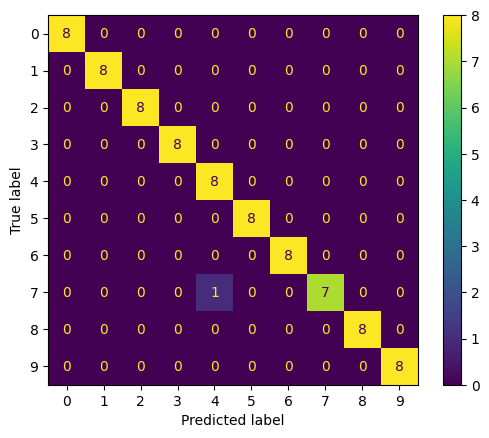

Epoch 1/15, Step 1/21, Loss: 2.4315
Epoch 1/15, Step 2/21, Loss: 2.3363
Epoch 1/15, Step 3/21, Loss: 2.2774
Epoch 1/15, Step 4/21, Loss: 2.1820
Epoch 1/15, Step 5/21, Loss: 2.2972
Epoch 1/15, Step 6/21, Loss: 2.1952
Epoch 1/15, Step 7/21, Loss: 2.1159
Epoch 1/15, Step 8/21, Loss: 2.1335
Epoch 1/15, Step 9/21, Loss: 1.9003
Epoch 1/15, Step 10/21, Loss: 1.9966
Epoch 1/15, Step 11/21, Loss: 1.9520
Epoch 1/15, Step 12/21, Loss: 1.8859
Epoch 1/15, Step 13/21, Loss: 1.8127
Epoch 1/15, Step 14/21, Loss: 1.7653
Epoch 1/15, Step 15/21, Loss: 1.8199
Epoch 1/15, Step 16/21, Loss: 1.7538
Epoch 1/15, Step 17/21, Loss: 1.6971
Epoch 1/15, Step 18/21, Loss: 1.5622
Epoch 1/15, Step 19/21, Loss: 1.7131
Epoch 1/15, Step 20/21, Loss: 1.8340
Epoch 1/15, Step 21/21, Loss: 1.3887
Epoch 1 average loss: 1.954780726205735
Epoch 2/15, Step 1/21, Loss: 1.4286
Epoch 2/15, Step 2/21, Loss: 1.2577
Epoch 2/15, Step 3/21, Loss: 1.4411
Epoch 2/15, Step 4/21, Loss: 1.3768
Epoch 2/15, Step 5/21, Loss: 1.2105
Epoch 2/15, 

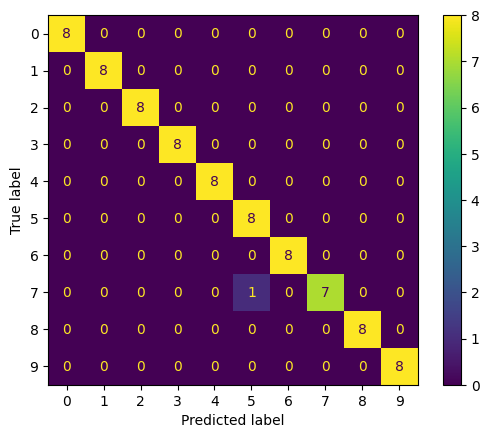

Epoch 1/15, Step 1/21, Loss: 2.2094
Epoch 1/15, Step 2/21, Loss: 2.2351
Epoch 1/15, Step 3/21, Loss: 2.3746
Epoch 1/15, Step 4/21, Loss: 2.3253
Epoch 1/15, Step 5/21, Loss: 2.2066
Epoch 1/15, Step 6/21, Loss: 2.2437
Epoch 1/15, Step 7/21, Loss: 2.0838
Epoch 1/15, Step 8/21, Loss: 2.1049
Epoch 1/15, Step 9/21, Loss: 2.0122
Epoch 1/15, Step 10/21, Loss: 2.0104
Epoch 1/15, Step 11/21, Loss: 2.0160
Epoch 1/15, Step 12/21, Loss: 1.8793
Epoch 1/15, Step 13/21, Loss: 2.0170
Epoch 1/15, Step 14/21, Loss: 1.8901
Epoch 1/15, Step 15/21, Loss: 1.8409
Epoch 1/15, Step 16/21, Loss: 1.8041
Epoch 1/15, Step 17/21, Loss: 1.6999
Epoch 1/15, Step 18/21, Loss: 1.8088
Epoch 1/15, Step 19/21, Loss: 1.6796
Epoch 1/15, Step 20/21, Loss: 1.5515
Epoch 1/15, Step 21/21, Loss: 1.4898
Epoch 1 average loss: 1.9753875391823905
Epoch 2/15, Step 1/21, Loss: 1.5903
Epoch 2/15, Step 2/21, Loss: 1.3526
Epoch 2/15, Step 3/21, Loss: 1.3966
Epoch 2/15, Step 4/21, Loss: 1.4953
Epoch 2/15, Step 5/21, Loss: 1.4797
Epoch 2/15,

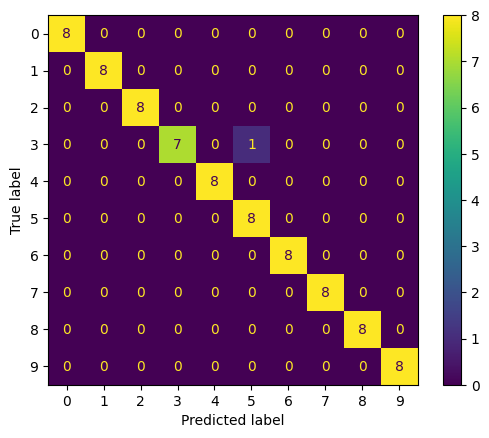

Médias das precisões: [1.         1.         1.         1.         0.96296296 0.92592593
 1.         1.         1.         1.        ]
Médias dos recalls: [1.         1.         1.         0.95833333 1.         1.
 1.         0.91666667 1.         1.        ]


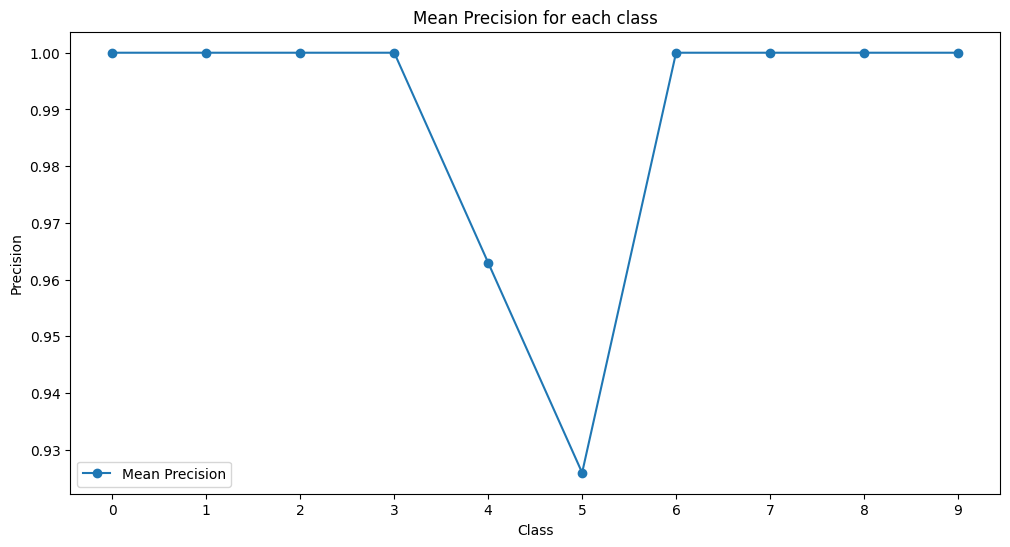

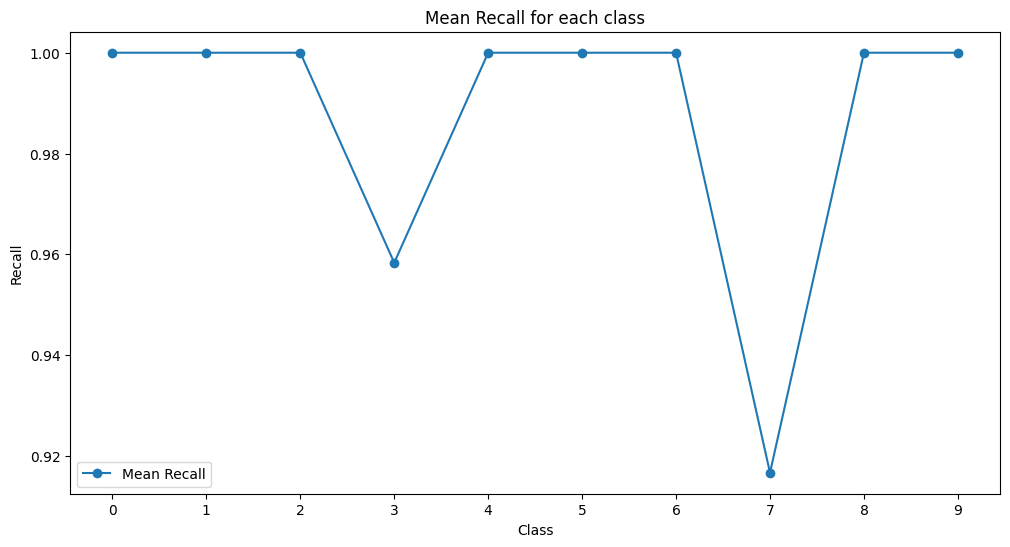

In [22]:
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np

train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'
balanced_dataset_path = 'data-students/balanced1_data/'

# Parâmetros de imagem e batch size
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

# Transformação das imagens
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)), transforms.ToTensor()])
traffic_signals_dataset = datasets.ImageFolder(root=balanced_dataset_path, transform=transform)

# Definição do modelo
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        self.fc1 = nn.Linear(1568, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def train_model(model, criterion, optimizer, train_dataset_loader, num_epochs=10, device='cpu'):
        model.to(device)
        for epoch in range(num_epochs):
            cumulative_loss = 0
            for batch_idx, (data, target) in enumerate(train_dataset_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
                cumulative_loss += loss.item()
            print(f"Epoch {epoch+1} average loss: {cumulative_loss/len(train_dataset_loader)}")
        return model.to("cpu")

# Configuração do dispositivo
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")

num_classes = len(traffic_signals_dataset.classes)
print(num_classes)
print(device)

def train_and_evaluate():
    # Divisão dos dados em treino, validação e teste (10% para validação, 10% para teste)
    train_val_idx, test_idx = train_test_split(
        range(len(traffic_signals_dataset)),
        test_size=0.1,
        shuffle=True,
        stratify=traffic_signals_dataset.targets
    )

    train_idx, valid_idx = train_test_split(
        train_val_idx,
        test_size=0.1,
        shuffle=True,
        stratify=[traffic_signals_dataset.targets[i] for i in train_val_idx]
    )

    train_subset = Subset(traffic_signals_dataset, train_idx)
    valid_subset = Subset(traffic_signals_dataset, valid_idx)
    test_subset = Subset(traffic_signals_dataset, test_idx)

    train_dataset_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    validation_dataset_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataset_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Treinamento do modelo
    model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 15

    ccnn = CustomCNN.train_model(model, criterion, optimizer, train_dataset_loader, num_epochs, device)

    return test_model(ccnn, test_dataset_loader)

# Avaliação do modelo
def test_model(model, dataset_loader):
    y_real = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))
    
    # Generate the classification report
    report = classification_report(y_real, y_pred, output_dict=True)
    cm = confusion_matrix(y_real, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    # Extract precision and recall for each class
    precisions = []
    recalls = []
    for i in range(num_classes):
        precisions.append(report[str(i)]['precision'])
        recalls.append(report[str(i)]['recall'])

    return precisions, recalls

# Executar o treinamento e avaliação 3 vezes
all_precisions = []
all_recalls = []

for i in range(3):
    precisions, recalls = train_and_evaluate()
    all_precisions.append(precisions)
    all_recalls.append(recalls)

# Calcular as médias de precisão e recall
mean_precisions = np.mean(all_precisions, axis=0)
mean_recalls = np.mean(all_recalls, axis=0)

print("Médias das precisões:", mean_precisions)
print("Médias dos recalls:", mean_recalls)

# Plotting Precision and Recall for each class
classes = list(range(num_classes))

# Primeiro gráfico: Precision para cada classe
plt.figure(figsize=(12, 6))
plt.plot(classes, mean_precisions, marker='o', label='Mean Precision')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Mean Precision for each class')
plt.xticks(classes)
plt.legend()
plt.show()

# Segundo gráfico: Recall para cada classe
plt.figure(figsize=(12, 6))
plt.plot(classes, mean_recalls, marker='o', label='Mean Recall')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Mean Recall for each class')
plt.xticks(classes)
plt.legend()
plt.show()



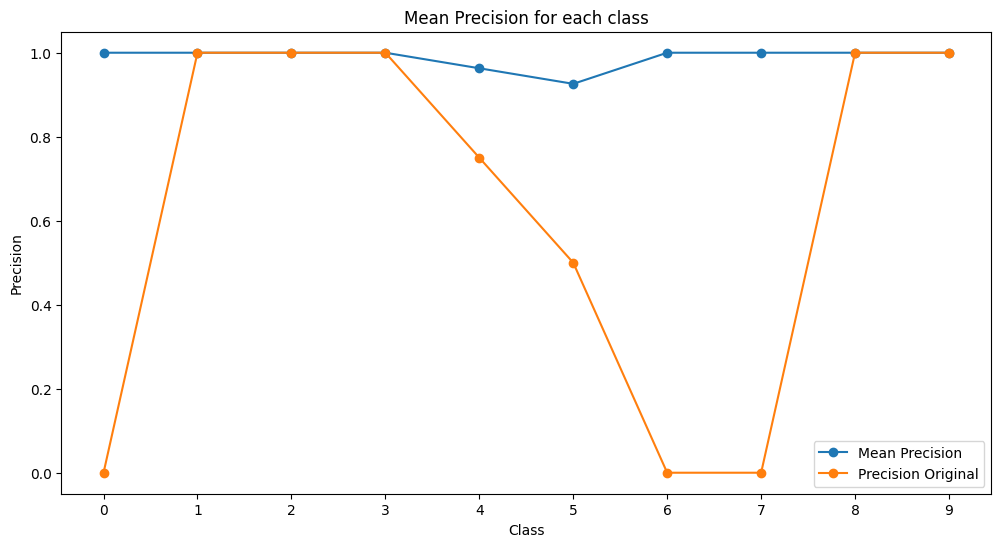

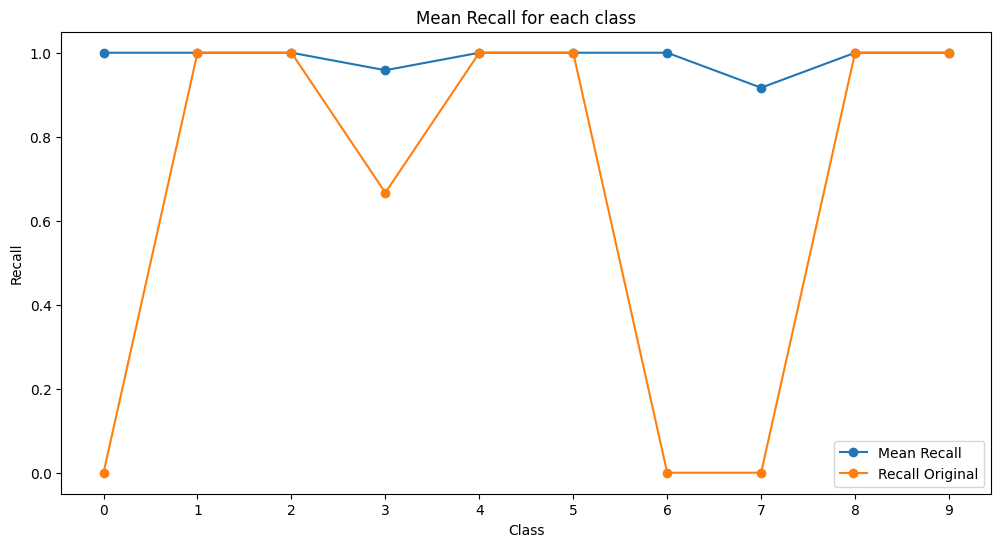

In [23]:
# Primeiro gráfico: Precision para cada classe
plt.figure(figsize=(12, 6))
plt.plot(classes, mean_precisions, marker='o', label='Mean Precision')
plt.plot(classes,precisions_original, marker='o', label='Precision Original')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Mean Precision for each class')
plt.xticks(classes)
plt.legend()
plt.show()

# Segundo gráfico: Recall para cada classe
plt.figure(figsize=(12, 6))
plt.plot(classes, mean_recalls, marker='o', label='Mean Recall')
plt.plot(classes,recalls_original, marker='o', label='Recall Original')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Mean Recall for each class')
plt.xticks(classes)
plt.legend()
plt.show()

# Calcular FID e SSIM

c:\Users\alice\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alice\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score for class 12: 672.3512573242188
FID Score for class 13: 1997.298583984375
FID Score for class 24: 1356.998779296875
FID Score for class 38: 659.1317138671875
FID Score for class 39: 659.1505126953125
FID Score for class 44: 345.17413330078125
FID Score for class 46: 447.69793701171875
FID Score for class 49: 399.510986328125
FID Score for class 50: 381.50360107421875
FID Score for class 6: 449.59576416015625


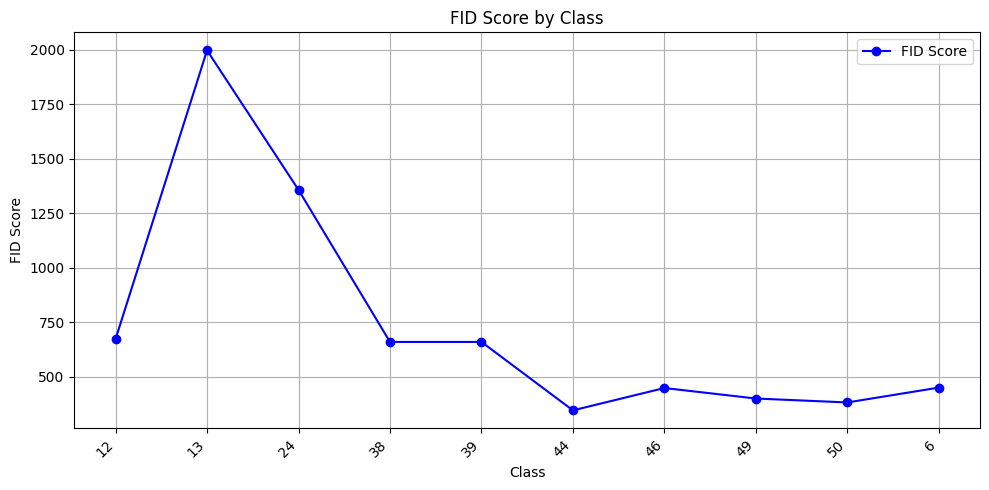

In [13]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
import os
from PIL import Image
from scipy.linalg import sqrtm
import numpy as np
import matplotlib.pyplot as plt

IMG_WIDTH = 75
IMG_HEIGHT = 75

transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),  
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aumentadas_path = 'generated_samples2/'
train_dataset_path = 'data-students/TRAIN'

# Initialize InceptionV3 model
model = inception_v3(pretrained=True, transform_input=False)
model.eval()

def calculate_fid(model, images1, images2):
   
    model.eval()

    # Forward pass through the model
    with torch.no_grad():
        features1 = model(images1).detach()
        features2 = model(images2).detach()

    # Flatten the features
    features1 = features1.view(features1.size(0), -1)
    features2 = features2.view(features2.size(0), -1)

    # Compute the mean and covariance across the feature dimension
    mu1, sigma1 = features1.mean(dim=0), torch.cov(features1.T)
    mu2, sigma2 = features2.mean(dim=0), torch.cov(features2.T)

    # Calculate sum squared difference between means
    ssdiff = torch.sum((mu1 - mu2) ** 2)

    # Calculate sqrt of product between covariances
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + torch.trace(sigma1 + sigma2 - 2.0 * torch.tensor(covmean, dtype=torch.float32))
    return fid.item()

# Function to load images for a class
def load_images_for_class(path, transform):
    images = []
    for img_name in os.listdir(path):
        if not img_name.startswith('.'):
            img_path = os.path.join(path, img_name)
            try:
                img = Image.open(img_path)
                img_tensor = transform(img).unsqueeze(0)
                images.append(img_tensor)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return torch.cat(images)

# Calculate FID for each class
fid_scores = []
classes = sorted([class_name for class_name in os.listdir(train_dataset_path) if not class_name.startswith('.')])

for class_idx, class_name in enumerate(classes):
    class_path_train = os.path.join(train_dataset_path, class_name)
    class_path_augmented = os.path.join(aumentadas_path, class_name)

    # Load images for the current class from both datasets
    images1 = load_images_for_class(class_path_train, transform)
    images2 = load_images_for_class(class_path_augmented, transform)

    if len(images1) == 0 or len(images2) == 0:
        print(f"Skipping class {class_name} due to lack of images.")
        continue

    # Calculate the FID score for the current class
    fid_score = calculate_fid(model, images1, images2)
    fid_scores.append(fid_score)
    print(f"FID Score for class {class_name}: {fid_score}")

# Plot FID scores by class
plt.figure(figsize=(10, 5))
plt.plot(classes, fid_scores, marker='o', color='blue', label='FID Score')
plt.xlabel('Class')
plt.ylabel('FID Score')
plt.title('FID Score by Class')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Average SSIM for class 12: 0.13491328060626984
Average SSIM for class 13: 0.17262396216392517
Average SSIM for class 24: 0.4358786344528198
Average SSIM for class 38: 0.05923670530319214
Average SSIM for class 39: 0.18218998610973358
Average SSIM for class 44: 0.0359693318605423
Average SSIM for class 46: 0.32258763909339905
Average SSIM for class 49: 0.2797134518623352
Average SSIM for class 50: 0.16299259662628174
Average SSIM for class 6: 0.07953984290361404


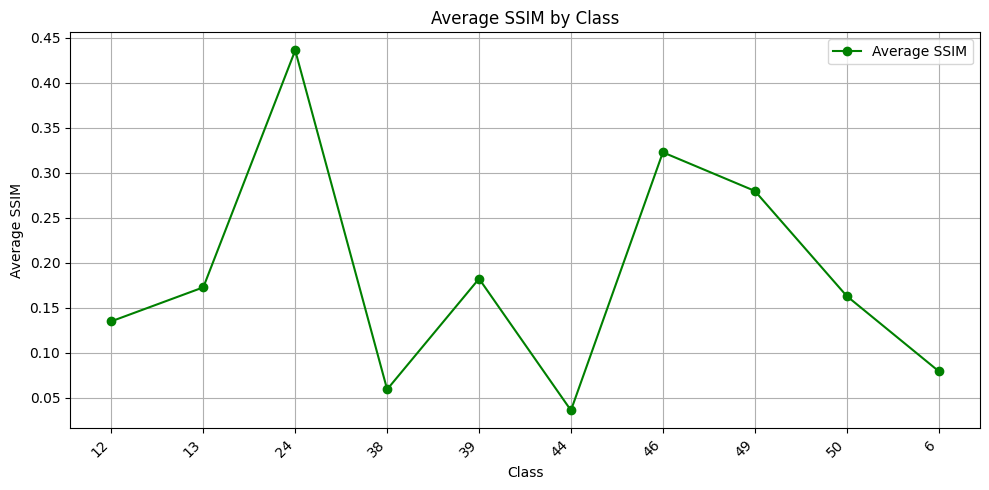

In [14]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

IMG_WIDTH = 75
IMG_HEIGHT = 75

transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),  # Resize to the expected input size of InceptionV3
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),  # Convert PIL image back to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def calculate_ssim(img1, img2):
    img1 = img1.squeeze().numpy() 
    img2 = img2.squeeze().numpy()  
    h, w = img1.shape[:2]
    win_size = min(h, w, 7)  
    if win_size % 2 == 0:
        win_size -= 1  # Torna o tamanho da janela ímpar
    return ssim(img1, img2, multichannel=True, win_size=win_size, data_range=1.0, channel_axis=-1)

def load_images_for_class(path, transform):
    images = []
    for img_name in os.listdir(path):
        if not img_name.startswith('.'):  # Ignorar ficheiros que começam com "."
            img_path = os.path.join(path, img_name)
            try:
                img = Image.open(img_path)
                img_tensor = transform(img).unsqueeze(0)
                images.append(img_tensor)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return torch.cat(images)

ssim_scores = []
classes = sorted([class_name for class_name in os.listdir(train_dataset_path) if not class_name.startswith('.')])

for class_idx, class_name in enumerate(classes):
    class_path_train = os.path.join(train_dataset_path, class_name)
    class_path_augmented = os.path.join(aumentadas_path, class_name)

    # Load images for the current class from both datasets
    images1 = load_images_for_class(class_path_train, transform)
    images2 = load_images_for_class(class_path_augmented, transform)

    if len(images1) == 0 or len(images2) == 0:
        print(f"Skipping class {class_name} due to lack of images.")
        continue

    # Calculate SSIM score for each pair of images
    class_ssim_scores = []
    for img1, img2 in zip(images1, images2):
        ssim_score = calculate_ssim(img1.squeeze(), img2.squeeze())
        class_ssim_scores.append(ssim_score)

    # Average SSIM score for the current class
    average_ssim = np.mean(class_ssim_scores)
    ssim_scores.append(average_ssim)
    print(f"Average SSIM for class {class_name}: {average_ssim}")

# Plot SSIM scores by class
plt.figure(figsize=(10, 5))
plt.plot(classes, ssim_scores, marker='o', color='green', label='Average SSIM')
plt.xlabel('Class')
plt.ylabel('Average SSIM')
plt.title('Average SSIM by Class')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

